# PySpark Online Retail II Dataset Analysis

This notebook demonstrates how to load and analyze the Online Retail II dataset using PySpark in Google Colab.


# 2. Data Understanding

## 1. Install Required Packages

First, install PySpark and related dependencies in Google Colab.


In [1]:
# Install required packages
%pip install pyspark pandas openpyxl


## 2. Import Libraries and Initialize Spark Session


In [2]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import col, sum as spark_sum, count, when, isnan, isnull, desc, min as spark_min, max as spark_max
from pyspark.sql import functions as F
import pandas as pd
import os

# Set environment variables for Windows
os.environ['PYSPARK_PYTHON'] = 'python'
os.environ['PYSPARK_DRIVER_PYTHON'] = 'python'

# Initialize Spark session with enhanced configuration for Windows
spark = SparkSession.builder \
    .appName("OnlineRetailAnalysis") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .config("spark.sql.execution.arrow.maxRecordsPerBatch", "10000") \
    .config("spark.driver.memory", "2g") \
    .config("spark.executor.memory", "2g") \
    .config("spark.sql.execution.arrow.pyspark.fallback.enabled", "true") \
    .config("spark.python.worker.timeout", "1200") \
    .config("spark.python.worker.reuse", "false") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .config("spark.sql.execution.pythonUDF.arrow.enabled", "true") \
    .config("spark.sql.adaptive.skewJoin.enabled", "true") \
    .config("spark.network.timeout", "800s") \
    .config("spark.rpc.askTimeout", "800s") \
    .config("spark.rpc.lookupTimeout", "800s") \
    .config("spark.sql.broadcastTimeout", "800s") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "false") \
    .master("local[*]") \
    .getOrCreate()

# Set log level to reduce output noise
spark.sparkContext.setLogLevel("WARN")

print("Spark session initialized successfully!")
print(f"Spark version: {spark.version}")
print(f"Spark UI: {spark.sparkContext.uiWebUrl}")


Spark session initialized successfully!
Spark version: 3.5.1
Spark UI: http://50db9da82bb4:4040


## 3. Load Data from GitHub

Since PySpark cannot directly read Excel files, we use pandas to read from GitHub and then convert to Spark DataFrame.


In [3]:
# Use pandas to read Excel file from GitHub (PySpark doesn't support Excel directly)
import pandas as pd
print("Reading Excel file from GitHub...")

# GitHub repository information
github_user = "Hachi630"
github_repo = "BDAS"
file_path = "online_retail_II.xlsx"

# Construct GitHub raw URL
github_url = f"https://raw.githubusercontent.com/{github_user}/{github_repo}/main/{file_path}"

# Read Excel file with multiple sheets
print("Loading data from both sheets (2009-2010 and 2010-2011)...")
excel_data = pd.read_excel(github_url, sheet_name=None)  # Read all sheets

# Get the two sheets
sheet_2009_2010 = excel_data['Year 2009-2010']
sheet_2010_2011 = excel_data['Year 2010-2011']

print(f"2009-2010 data shape: {sheet_2009_2010.shape}")
print(f"2010-2011 data shape: {sheet_2010_2011.shape}")

# Combine both datasets
pandas_df = pd.concat([sheet_2009_2010, sheet_2010_2011], ignore_index=True)
print(f"Combined data shape: {pandas_df.shape}")

# Convert pandas DataFrame to Spark DataFrame
df = spark.createDataFrame(pandas_df)

# Clean up pandas objects to free memory
del pandas_df, sheet_2009_2010, sheet_2010_2011, excel_data

print("Data successfully loaded from GitHub into Spark DataFrame!")
print("Pandas objects cleaned up to free memory.")


Reading Excel file from GitHub...
Loading data from both sheets (2009-2010 and 2010-2011)...
2009-2010 data shape: (525461, 8)
2010-2011 data shape: (541910, 8)
Combined data shape: (1067371, 8)
Data successfully loaded from GitHub into Spark DataFrame!
Pandas objects cleaned up to free memory.


## 4. Check Data Dimensions

Determine the number of rows and columns in the combined dataset.


In [4]:
# Check data dimensions using PySpark with error handling
print("=== Data Dimension Information ===")

try:
    # Get row count with retry mechanism
    print("Counting rows...")
    row_count = df.count()
    print(f"Dataset row count: {row_count:,}")

    # Get column count and names
    column_count = len(df.columns)
    column_names = df.columns

    print(f"Dataset column count: {column_count}")
    print(f"Column names: {column_names}")

    # Additional information
    print(f"\nDataset partitions: {df.rdd.getNumPartitions()}")
    print(f"Dataset storage level: {df.storageLevel}")

    print("✅ Data dimension check completed successfully!")

except Exception as e:
    print(f"❌ Error during data dimension check: {e}")
    print("\n🔧 Troubleshooting steps:")
    print("1. Restart the kernel and run all cells again")
    print("2. Check if Java is properly installed")
    print("3. Try reducing memory allocation in Spark config")
    print("4. Consider using pandas-only analysis for this dataset")

    # Fallback: try to get basic info without count()
    try:
        print("\n🔄 Attempting fallback analysis...")
        column_count = len(df.columns)
        column_names = df.columns
        print(f"Dataset column count: {column_count}")
        print(f"Column names: {column_names}")
        print("Note: Row count unavailable due to Spark connection issues")
    except Exception as e2:
        print(f"❌ Fallback also failed: {e2}")
        print("Please restart the kernel and try again.")


=== Data Dimension Information ===
Counting rows...
Dataset row count: 1,067,371
Dataset column count: 8
Column names: ['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'Price', 'Customer ID', 'Country']

Dataset partitions: 2
Dataset storage level: Serialized 1x Replicated
✅ Data dimension check completed successfully!


## 5. Data Quality Assessment

This section performs comprehensive data quality checks to identify potential issues in the dataset.


### 5.1 Missing Values Analysis


In [5]:
# Count nulls in each column with robust error handling
print("=== Missing Values Analysis ===")

# Try PySpark first, fallback to pandas if needed
USE_SPARK = True

try:
    # Test Spark connection first
    print("Testing Spark connection...")
    test_count = df.count()
    print(f"✅ Spark connection successful! Dataset has {test_count:,} records")

    # Count missing values in each column using PySpark
    print("Counting missing values using PySpark...")
    missing_counts = df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns])

    print("Missing values per column:")
    missing_counts.show()

    # Get total count for percentage calculation
    total_records = df.count()
    print(f"\nTotal records: {total_records:,}")

    # Calculate and display missing percentages
    print("\nMissing values summary:")
    missing_data = missing_counts.collect()[0]
    for col_name in df.columns:
        missing_count = missing_data[col_name]
        missing_pct = (missing_count / total_records) * 100
        print(f"{col_name}: {missing_count:,} ({missing_pct:.2f}%)")

        # Add specific comment for CustomerID
        if col_name == "Customer ID" and missing_count > 0:
            print(f"  → CustomerID has many missing entries ({missing_count:,} records)")
        elif missing_count == 0:
            print(f"  → {col_name} is complete (no missing values)")
        else:
            print(f"  → {col_name} has some missing values")

    print("✅ Missing values analysis completed successfully with PySpark!")

except Exception as e:
    print(f"❌ PySpark analysis failed: {e}")
    print("\n🔄 Switching to pandas analysis...")
    USE_SPARK = False

    # Fallback to pandas analysis
    try:
        # Re-read data with pandas for analysis
        print("Re-reading data with pandas for analysis...")
        github_url = "https://raw.githubusercontent.com/Hachi630/BDAS/main/online_retail_II.xlsx"
        excel_data = pd.read_excel(github_url, sheet_name=None)
        sheet_2009_2010 = excel_data['Year 2009-2010']
        sheet_2010_2011 = excel_data['Year 2010-2011']
        pandas_df = pd.concat([sheet_2009_2010, sheet_2010_2011], ignore_index=True)

        print("Missing values per column:")
        missing_counts = pandas_df.isnull().sum()
        print(missing_counts)

        total_records = len(pandas_df)
        print(f"\nTotal records: {total_records:,}")

        # Calculate and display missing percentages
        print("\nMissing values summary:")
        for col_name in missing_counts.index:
            missing_count = missing_counts[col_name]
            missing_pct = (missing_count / total_records) * 100
            print(f"{col_name}: {missing_count:,} ({missing_pct:.2f}%)")

            # Add specific comment for CustomerID
            if col_name == "Customer ID" and missing_count > 0:
                print(f"  → CustomerID has many missing entries ({missing_count:,} records)")
            elif missing_count == 0:
                print(f"  → {col_name} is complete (no missing values)")
            else:
                print(f"  → {col_name} has some missing values")

        print("✅ Missing values analysis completed successfully with pandas!")

    except Exception as e2:
        print(f"❌ Pandas analysis also failed: {e2}")
        print("Please check your internet connection and try again.")


=== Missing Values Analysis ===
Testing Spark connection...
✅ Spark connection successful! Dataset has 1,067,371 records
Counting missing values using PySpark...
Missing values per column:
+-------+---------+-----------+--------+-----------+-----+-----------+-------+
|Invoice|StockCode|Description|Quantity|InvoiceDate|Price|Customer ID|Country|
+-------+---------+-----------+--------+-----------+-----+-----------+-------+
|      0|        0|          0|       0|          0|    0|          0|      0|
+-------+---------+-----------+--------+-----------+-----+-----------+-------+


Total records: 1,067,371

Missing values summary:
Invoice: 0 (0.00%)
  → Invoice is complete (no missing values)
StockCode: 0 (0.00%)
  → StockCode is complete (no missing values)
Description: 0 (0.00%)
  → Description is complete (no missing values)
Quantity: 0 (0.00%)
  → Quantity is complete (no missing values)
InvoiceDate: 0 (0.00%)
  → InvoiceDate is complete (no missing values)
Price: 0 (0.00%)
  → Price 

In [6]:
# Missing Values (robust check: null, NaN, empty strings, 'null'-like)
from pyspark.sql.types import StringType, NumericType, TimestampType, DateType

print("=== Missing Values Analysis (Robust) ===")

schema_fields = {f.name: f.dataType for f in df.schema.fields}

def missing_agg_for(col_name: str):
	dtype = schema_fields[col_name]
	c = F.col(col_name)
	if isinstance(dtype, NumericType):
		cond = c.isNull() | F.isnan(c)
	elif isinstance(dtype, StringType):
		cond = c.isNull() | (F.trim(c) == "") | (F.lower(F.trim(c)).isin("na", "n/a", "null", "none"))
	else:
		cond = c.isNull()
	return F.sum(F.when(cond, 1).otherwise(0)).alias(col_name)

exprs = [missing_agg_for(c) for c in df.columns]
robust_missing = df.agg(*exprs)

print("Missing values per column (robust):")
robust_missing.show(truncate=False)

# Percentages
total_records = df.count()
row = robust_missing.collect()[0]
print("\nMissing values summary (count and %):")
for c in df.columns:
	mc = int(row[c])
	pct = (mc / total_records) * 100 if total_records else 0
	status = "complete" if mc == 0 else ("many missing" if mc > 0.05 * total_records else "some missing")
	print(f"{c}: {mc:,} ({pct:.2f}%)  → {status}")
	if c == "Customer ID" and mc > 0:
		print(f"  Note: 'Customer ID' often has many missing entries in this dataset.")


=== Missing Values Analysis (Robust) ===
Missing values per column (robust):
+-------+---------+-----------+--------+-----------+-----+-----------+-------+
|Invoice|StockCode|Description|Quantity|InvoiceDate|Price|Customer ID|Country|
+-------+---------+-----------+--------+-----------+-----+-----------+-------+
|0      |0        |0          |0       |0          |0    |243007     |0      |
+-------+---------+-----------+--------+-----------+-----+-----------+-------+


Missing values summary (count and %):
Invoice: 0 (0.00%)  → complete
StockCode: 0 (0.00%)  → complete
Description: 0 (0.00%)  → complete
Quantity: 0 (0.00%)  → complete
InvoiceDate: 0 (0.00%)  → complete
Price: 0 (0.00%)  → complete
Customer ID: 243,007 (22.77%)  → many missing
  Note: 'Customer ID' often has many missing entries in this dataset.
Country: 0 (0.00%)  → complete


### 5.2 Numeric Values Validity Check


In [7]:
# Identify records with non-positive prices or zero quantity with error handling
print("=== Numeric Values Validity Check ===")

if USE_SPARK:
    try:
        print("Using PySpark for numeric validity analysis...")

        # Check for non-positive Price values
        invalid_price_count = df.filter(F.col("Price") <= 0).count()
        print(f"Records with Price <= 0: {invalid_price_count:,}")

        if invalid_price_count > 0:
            print("\nSample records with invalid prices:")
            df.filter(F.col("Price") <= 0).select("Invoice", "StockCode", "Quantity", "Price").show(5)

        # Check for zero Quantity values
        zero_quantity_count = df.filter(F.col("Quantity") == 0).count()
        print(f"\nRecords with Quantity = 0: {zero_quantity_count:,}")

        if zero_quantity_count > 0:
            print("\nSample records with zero quantity:")
            df.filter(F.col("Quantity") == 0).show(5)

        # Check for negative quantities (returns)
        negative_quantity_count = df.filter(F.col("Quantity") < 0).count()
        print(f"\nRecords with Quantity < 0 (returns): {negative_quantity_count:,}")

        print("✅ PySpark numeric validity check completed!")

    except Exception as e:
        print(f"❌ PySpark numeric check failed: {e}")
        print("🔄 Switching to pandas analysis...")
        USE_SPARK = False

if not USE_SPARK:
    try:
        print("Using pandas for numeric validity analysis...")

        # Check for non-positive Price values
        invalid_price_mask = pandas_df["Price"] <= 0
        invalid_price_count = invalid_price_mask.sum()
        print(f"Records with Price <= 0: {invalid_price_count:,}")

        if invalid_price_count > 0:
            print("\nSample records with invalid prices:")
            print(pandas_df[invalid_price_mask][["Invoice", "StockCode", "Quantity", "Price"]].head())

        # Check for zero Quantity values
        zero_quantity_mask = pandas_df["Quantity"] == 0
        zero_quantity_count = zero_quantity_mask.sum()
        print(f"\nRecords with Quantity = 0: {zero_quantity_count:,}")

        if zero_quantity_count > 0:
            print("\nSample records with zero quantity:")
            print(pandas_df[zero_quantity_mask].head())

        # Check for negative quantities (returns)
        negative_quantity_mask = pandas_df["Quantity"] < 0
        negative_quantity_count = negative_quantity_mask.sum()
        print(f"\nRecords with Quantity < 0 (returns): {negative_quantity_count:,}")

        print("✅ Pandas numeric validity check completed!")

    except Exception as e:
        print(f"❌ Pandas numeric check failed: {e}")

# Summary comments
print("\n=== Validity Summary ===")
if invalid_price_count > 0:
    print(f"⚠️  Found {invalid_price_count:,} records with non-positive prices (possibly freebies)")
else:
    print("✅ All prices are positive")

if zero_quantity_count > 0:
    print(f"⚠️  Found {zero_quantity_count:,} records with zero quantity (unusual - could indicate data entry errors)")
else:
    print("✅ No zero quantity records found")

if negative_quantity_count > 0:
    print(f"ℹ️  Found {negative_quantity_count:,} return transactions (negative quantities)")


=== Numeric Values Validity Check ===
Using PySpark for numeric validity analysis...
Records with Price <= 0: 6,207

Sample records with invalid prices:
+-------+---------+--------+-----+
|Invoice|StockCode|Quantity|Price|
+-------+---------+--------+-----+
| 489464|    21733|     -96|  0.0|
| 489463|    71477|    -240|  0.0|
| 489467|   85123A|    -192|  0.0|
| 489521|    21646|     -50|  0.0|
| 489655|    20683|     -44|  0.0|
+-------+---------+--------+-----+
only showing top 5 rows


Records with Quantity = 0: 0

Records with Quantity < 0 (returns): 22,950
✅ PySpark numeric validity check completed!

=== Validity Summary ===
⚠️  Found 6,207 records with non-positive prices (possibly freebies)
✅ No zero quantity records found
ℹ️  Found 22,950 return transactions (negative quantities)


## 6. Exploratory Data Analysis (EDA)

Perform comprehensive exploratory data analysis using PySpark.


### 6.1 Key Dataset Metrics


In [8]:
# Calculate number of distinct products and customers
print("=== Key Dataset Metrics ===")

# Calculate distinct counts using Spark
unique_products = df.select("StockCode").distinct().count()
unique_customers = df.select("Customer ID").distinct().count()

# Calculate total revenue
total_revenue = df.agg(F.sum(F.col("Quantity") * F.col("Price")).alias("TotalRevenue")).collect()[0]["TotalRevenue"]

# Calculate total transactions
total_transactions = df.count()

print(f"Total Transactions: {total_transactions:,}")
print(f"Unique Products (StockCode): {unique_products:,}")
print(f"Unique Customers: {unique_customers:,}")
print(f"Total Revenue: £{total_revenue:,.2f}")

# Additional metrics
avg_order_value = df.agg(F.avg(F.col("Quantity") * F.col("Price")).alias("AvgOrderValue")).collect()[0]["AvgOrderValue"]
print(f"Average Order Value: £{avg_order_value:.2f}")

# Data preview
print("\n=== Data Preview ===")
df.show(5, truncate=False)

print("\n=== Data Schema ===")
df.printSchema()


=== Key Dataset Metrics ===
Total Transactions: 1,067,371
Unique Products (StockCode): 5,305
Unique Customers: 5,943
Total Revenue: £19,287,250.57
Average Order Value: £18.07

=== Data Preview ===
+-------+---------+-----------------------------------+--------+-------------------+-----+-----------+--------------+
|Invoice|StockCode|Description                        |Quantity|InvoiceDate        |Price|Customer ID|Country       |
+-------+---------+-----------------------------------+--------+-------------------+-----+-----------+--------------+
|489434 |85048    |15CM CHRISTMAS GLASS BALL 20 LIGHTS|12      |2009-12-01 07:45:00|6.95 |13085.0    |United Kingdom|
|489434 |79323P   |PINK CHERRY LIGHTS                 |12      |2009-12-01 07:45:00|6.75 |13085.0    |United Kingdom|
|489434 |79323W   | WHITE CHERRY LIGHTS               |12      |2009-12-01 07:45:00|6.75 |13085.0    |United Kingdom|
|489434 |22041    |RECORD FRAME 7" SINGLE SIZE        |48      |2009-12-01 07:45:00|2.1  |13085

## 7. Data Quality Summary Report


In [9]:
# Data Quality Summary Report
print("=" * 60)
print("           DATA QUALITY ASSESSMENT SUMMARY")
print("=" * 60)

print("\n📊 DATASET OVERVIEW:")
total_records = df.count()
total_columns = len(df.columns)

print(f"   • Total Records: {total_records:,}")
print(f"   • Total Columns: {total_columns}")
print(f"   • Analysis Engine: PySpark")

print("\n🔍 DATA QUALITY ISSUES IDENTIFIED:")

# Missing Values Summary
print("\n1. MISSING VALUES:")
missing_counts = df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns])
missing_data = missing_counts.collect()[0]
for col_name in df.columns:
    missing_count = missing_data[col_name]
    missing_pct = (missing_count / total_records) * 100
    if missing_count > 0:
        print(f"   • {col_name}: {missing_count:,} ({missing_pct:.2f}%)")

# Numeric Validity Summary
print("\n2. NUMERIC VALIDITY:")
invalid_price_count = df.filter(F.col("Price") <= 0).count()
zero_quantity_count = df.filter(F.col("Quantity") == 0).count()
negative_quantity_count = df.filter(F.col("Quantity") < 0).count()

if invalid_price_count > 0:
    print(f"   • Non-positive prices: {invalid_price_count:,}")
if zero_quantity_count > 0:
    print(f"   • Zero quantities: {zero_quantity_count:,}")
if negative_quantity_count > 0:
    print(f"   • Negative quantities (returns): {negative_quantity_count:,}")

# Returns and Cancellations Summary
print("\n3. RETURNS & CANCELLATIONS:")
num_cancelled = df.filter(F.col("Invoice").startswith("C")).count()
num_returns = df.filter(F.col("Quantity") < 0).count()

print(f"   • Cancelled invoices: {num_cancelled:,}")
print(f"   • Return transactions: {num_returns:,}")

# Duplicates Summary
print("\n4. DUPLICATE RECORDS:")
unique_rows = df.dropDuplicates().count()
num_duplicates = total_records - unique_rows
if num_duplicates > 0:
    print(f"   • Duplicate records: {num_duplicates:,}")
else:
    print("   • No duplicate records found")

# Date Range Summary
print("\n5. DATE RANGE CONSISTENCY:")
date_range = df.select(F.min("InvoiceDate").alias("MinDate"), F.max("InvoiceDate").alias("MaxDate"))
date_info = date_range.collect()[0]
min_date = date_info["MinDate"]
max_date = date_info["MaxDate"]

print(f"   • Date range: {min_date} to {max_date}")
print(f"   • Expected range: 2009-12-01 to 2011-12-09")

print("\n📋 RECOMMENDATIONS:")
print("   • CustomerID missing values: Consider impact on customer analysis")
print("   • Return transactions: Account for net vs gross sales calculations")
print("   • Date range: Verify business context for partial years")
if num_duplicates > 0:
    print("   • Duplicates: Consider removing for accurate analysis")
if invalid_price_count > 0 or zero_quantity_count > 0:
    print("   • Invalid values: Review business rules for data cleaning")

print("\n" + "=" * 60)
print("           END OF DATA QUALITY ASSESSMENT")
print("=" * 60)


           DATA QUALITY ASSESSMENT SUMMARY

📊 DATASET OVERVIEW:
   • Total Records: 1,067,371
   • Total Columns: 8
   • Analysis Engine: PySpark

🔍 DATA QUALITY ISSUES IDENTIFIED:

1. MISSING VALUES:

2. NUMERIC VALIDITY:
   • Non-positive prices: 6,207
   • Negative quantities (returns): 22,950

3. RETURNS & CANCELLATIONS:
   • Cancelled invoices: 19,494
   • Return transactions: 22,950

4. DUPLICATE RECORDS:
   • Duplicate records: 34,335

5. DATE RANGE CONSISTENCY:
   • Date range: 2009-12-01 07:45:00 to 2011-12-09 12:50:00
   • Expected range: 2009-12-01 to 2011-12-09

📋 RECOMMENDATIONS:
   • CustomerID missing values: Consider impact on customer analysis
   • Return transactions: Account for net vs gross sales calculations
   • Date range: Verify business context for partial years
   • Duplicates: Consider removing for accurate analysis
   • Invalid values: Review business rules for data cleaning

           END OF DATA QUALITY ASSESSMENT


## 8. Troubleshooting: Restart Spark Session

If you encounter connection timeout errors, run this cell to restart the Spark session.


In [10]:
# Restart Spark session if needed
print("🔄 Restarting Spark session...")

try:
    # Stop current session
    spark.stop()
    print("✅ Previous Spark session stopped")
except:
    print("ℹ️  No previous session to stop")

# Wait a moment
import time
time.sleep(2)

# Restart with optimized configuration
spark = SparkSession.builder \
    .appName("OnlineRetailAnalysis") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .config("spark.driver.memory", "1g") \
    .config("spark.executor.memory", "1g") \
    .config("spark.python.worker.timeout", "1800") \
    .config("spark.python.worker.reuse", "false") \
    .config("spark.network.timeout", "1200s") \
    .config("spark.rpc.askTimeout", "1200s") \
    .config("spark.rpc.lookupTimeout", "1200s") \
    .config("spark.sql.broadcastTimeout", "1200s") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "false") \
    .master("local[2]") \
    .getOrCreate()

spark.sparkContext.setLogLevel("WARN")

print("✅ New Spark session initialized!")
print(f"Spark version: {spark.version}")

# Test the connection
try:
    test_df = spark.range(10)
    test_count = test_df.count()
    print(f"✅ Connection test successful: {test_count} rows")
except Exception as e:
    print(f"❌ Connection test failed: {e}")
    print("Please check your Java installation and try again.")


🔄 Restarting Spark session...
✅ Previous Spark session stopped
✅ New Spark session initialized!
Spark version: 3.5.1
✅ Connection test successful: 10 rows


### 8.1 Fix Spark on Windows: stable local dir + session rebuild

This cell configures Spark to use a stable local directory on D: and rebuilds the session to avoid blockmgr/temp folder errors on Windows.


In [11]:
# Configure stable local dirs and rebuild Spark session (Windows)
import os, time
from pyspark.sql import SparkSession

# 1) Create stable directories on D: (adjust if needed)
stable_tmp = "D:/spark-tmp"
stable_wh  = "D:/spark-warehouse"

os.makedirs(stable_tmp, exist_ok=True)
os.makedirs(stable_wh,  exist_ok=True)

# 2) Environment vars so PySpark avoids system Temp
os.environ["PYSPARK_PYTHON"] = "python"
os.environ["PYSPARK_DRIVER_PYTHON"] = "python"
os.environ["PYSPARK_TEMP_DIR"] = stable_tmp
os.environ["TMP"] = stable_tmp
os.environ["TEMP"] = stable_tmp

# 3) Stop previous session if any
try:
    spark.stop()
except Exception:
    pass

# 4) Rebuild Spark with stable local dir and conservative timeouts
spark = SparkSession.builder \
    .appName("OnlineRetailAnalysis") \
    .master("local[2]") \
    .config("spark.local.dir", stable_tmp) \
    .config("spark.sql.warehouse.dir", stable_wh) \
    .config("spark.python.worker.timeout", "1800") \
    .config("spark.python.worker.reuse", "false") \
    .config("spark.network.timeout", "1200s") \
    .config("spark.rpc.askTimeout", "1200s") \
    .config("spark.rpc.lookupTimeout", "1200s") \
    .config("spark.sql.broadcastTimeout", "1200s") \
    .config("spark.sql.autoBroadcastJoinThreshold", "-1") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "false") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .getOrCreate()

spark.sparkContext.setLogLevel("WARN")
print("✅ Spark rebuilt with stable local dir:", stable_tmp)
print("Spark UI:", spark.sparkContext.uiWebUrl)

# Small sleep to let workers warm up
time.sleep(1)


✅ Spark rebuilt with stable local dir: D:/spark-tmp
Spark UI: http://50db9da82bb4:4040


In [12]:
# Connection self-test and safe repartition
print("Running Spark self-test...")
try:
    test = spark.range(10)
    print("Count test:", test.count())
    print("✅ Spark basic count OK")
except Exception as e:
    print("❌ Spark basic count failed:", e)

# If you already have df loaded, make it safer before heavy actions
try:
    from pyspark.storagelevel import StorageLevel
    df = df.repartition(2).persist(StorageLevel.MEMORY_ONLY)
    print("Repartitioned df to", df.rdd.getNumPartitions(), "partitions")
except Exception:
    pass


Running Spark self-test...
Count test: 10
✅ Spark basic count OK


## 9.Data Quality Summary Report (Robust)

This summary uses robust missing value rules (null/NaN/empty/"null"-like) and consolidates key data quality indicators.


In [13]:
# Robust Data Quality Summary (with Spark fallback handling)
from pyspark.sql.types import StringType, NumericType
from pyspark.storagelevel import StorageLevel
import pandas as pd

print("=" * 60)
print("         DATA QUALITY ASSESSMENT SUMMARY (ROBUST)")
print("=" * 60)

USE_SPARK = True

try:
	# Persist lightly to stabilize actions
	df_cached = df.repartition(2).persist(StorageLevel.MEMORY_ONLY)
	# Dataset overview (avoid heavy transformations)
	total_records = df_cached.selectExpr('count(*) as c').collect()[0]['c']
	print("\n📊 DATASET OVERVIEW:")
	print(f"   • Total Records: {total_records:,}")
	print(f"   • Total Columns: {len(df_cached.columns)}")

	# Robust missing values
	print("\n1. MISSING VALUES (Robust):")
	schema_fields = {f.name: f.dataType for f in df_cached.schema.fields}
	def miss_expr(cn):
		colx = F.col(cn)
		dt = schema_fields[cn]
		if isinstance(dt, NumericType):
			cond = colx.isNull() | F.isnan(colx)
		elif isinstance(dt, StringType):
			cond = colx.isNull() | (F.trim(colx) == "") | (F.lower(F.trim(colx)).isin("na","n/a","null","none"))
		else:
			cond = colx.isNull()
		return F.sum(F.when(cond, 1).otherwise(0)).alias(cn)

	robust_missing_df = df_cached.agg(*[miss_expr(c) for c in df_cached.columns])
	robust_row = robust_missing_df.collect()[0]
	any_missing = False
	for cn in df_cached.columns:
		mc = int(robust_row[cn])
		if mc > 0:
			any_missing = True
			pct = (mc / total_records) * 100
			print(f"   • {cn}: {mc:,} ({pct:.2f}%)")
	if not any_missing:
		print("   • No missing values detected under robust rules")

	# Numeric validity
	print("\n2. NUMERIC VALIDITY:")
	invalid_price_count = df_cached.filter(F.col("Price") <= 0).count()
	zero_quantity_count = df_cached.filter(F.col("Quantity") == 0).count()
	negative_quantity_count = df_cached.filter(F.col("Quantity") < 0).count()
	if invalid_price_count > 0:
		print(f"   • Non-positive prices: {invalid_price_count:,}")
	if zero_quantity_count > 0:
		print(f"   • Zero quantities: {zero_quantity_count:,}")
	if negative_quantity_count > 0:
		print(f"   • Negative quantities (returns): {negative_quantity_count:,}")

	# Returns and cancellations
	print("\n3. RETURNS & CANCELLATIONS:")
	num_cancelled = df_cached.filter(F.col("Invoice").startswith("C")).count()
	num_returns = df_cached.filter(F.col("Quantity") < 0).count()
	print(f"   • Cancelled invoices: {num_cancelled:,}")
	print(f"   • Return transactions: {num_returns:,}")

	# Duplicates
	print("\n4. DUPLICATE RECORDS:")
	unique_rows = df_cached.dropDuplicates().count()
	num_duplicates = total_records - unique_rows
	if num_duplicates > 0:
		print(f"   • Duplicate records: {num_duplicates:,}")
	else:
		print("   • No duplicate records found")

	# Date range
	print("\n5. DATE RANGE CONSISTENCY:")
	info = df_cached.select(F.min("InvoiceDate").alias("MinDate"), F.max("InvoiceDate").alias("MaxDate")).collect()[0]
	print(f"   • Date range: {info['MinDate']} to {info['MaxDate']}")
	print(f"   • Expected range: 2009-12-01 to 2011-12-09")

except Exception as e:
	# Spark failed → fallback to pandas so the section is never empty
	USE_SPARK = False
	print(f"❌ Spark failed in summary: {e}")
	print("🔄 Falling back to pandas for DATA QUALITY SUMMARY...")
	github_url = "https://raw.githubusercontent.com/Hachi630/BDAS/main/online_retail_II.xlsx"
	excel_data = pd.read_excel(github_url, sheet_name=None)
	sheet_2009_2010 = excel_data['Year 2009-2010']
	sheet_2010_2011 = excel_data['Year 2010-2011']
	pandas_df = pd.concat([sheet_2009_2010, sheet_2010_2011], ignore_index=True)

	total_records = len(pandas_df)
	print("\n📊 DATASET OVERVIEW:")
	print(f"   • Total Records: {total_records:,}")
	print(f"   • Total Columns: {len(pandas_df.columns)}")

	print("\n1. MISSING VALUES (Robust):")
	def _norm_str(x):
		return str(x).strip().lower() if isinstance(x, str) else x
	missing_counts = {}
	for c in pandas_df.columns:
		col = pandas_df[c]
		if col.dtype.kind in 'biufc':
			mc = int(col.isna().sum())
		else:
			lower = col.astype('string').str.strip().str.lower()
			mc = int(col.isna().sum() + (lower.isin(['','na','n/a','null','none']).sum()))
		missing_counts[c] = mc
	any_missing = False
	for c, mc in missing_counts.items():
		if mc > 0:
			any_missing = True
			pct = (mc / total_records) * 100
			print(f"   • {c}: {mc:,} ({pct:.2f}%)")
	if not any_missing:
		print("   • No missing values detected under robust rules (pandas)")

	print("\n2. NUMERIC VALIDITY:")
	inv = int((pandas_df['Price'] <= 0).sum()) if 'Price' in pandas_df.columns else 0
	zq = int((pandas_df['Quantity'] == 0).sum()) if 'Quantity' in pandas_df.columns else 0
	neg = int((pandas_df['Quantity'] < 0).sum()) if 'Quantity' in pandas_df.columns else 0
	if inv>0: print(f"   • Non-positive prices: {inv:,}")
	if zq>0: print(f"   • Zero quantities: {zq:,}")
	if neg>0: print(f"   • Negative quantities (returns): {neg:,}")

	print("\n3. RETURNS & CANCELLATIONS:")
	cancelled = int(pandas_df['Invoice'].astype(str).str.startswith('C').sum()) if 'Invoice' in pandas_df.columns else 0
	returns = neg
	print(f"   • Cancelled invoices: {cancelled:,}")
	print(f"   • Return transactions: {returns:,}")

	print("\n4. DUPLICATE RECORDS:")
	unique_rows = len(pandas_df.drop_duplicates())
	num_duplicates = total_records - unique_rows
	if num_duplicates > 0:
		print(f"   • Duplicate records: {num_duplicates:,}")
	else:
		print("   • No duplicate records found")

	print("\n5. DATE RANGE CONSISTENCY:")
	print(f"   • Date range: {pandas_df['InvoiceDate'].min()} to {pandas_df['InvoiceDate'].max()}")
	print(f"   • Expected range: 2009-12-01 to 2011-12-09")

finally:
	try:
		# Clean up cache if used
		df_cached.unpersist()
	except Exception:
		pass

print("\n📋 RECOMMENDATIONS:")
print("   • Address missing Customer IDs before customer-level analysis")
print("   • Account for returns/cancellations in net sales")
print("   • Review non-positive prices with business rules")
try:
	if USE_SPARK:
		if num_duplicates > 0:
			print("   • Remove duplicates to avoid double counting")
	else:
		if num_duplicates > 0:
			print("   • Remove duplicates to avoid double counting")
except Exception:
	pass

print("\n" + "=" * 60)
print("         END OF DATA QUALITY ASSESSMENT (ROBUST)")
print("=" * 60)


         DATA QUALITY ASSESSMENT SUMMARY (ROBUST)
❌ Spark failed in summary: An error occurred while calling o486.persist.
: java.lang.IllegalStateException: Cannot call methods on a stopped SparkContext.
This stopped SparkContext was created at:

org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.scala:58)
java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:62)
java.base/jdk.internal.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
java.base/java.lang.reflect.Constructor.newInstance(Constructor.java:490)
py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:247)
py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
py4j.Gateway.invoke(Gateway.java:238)
py4j.commands.ConstructorCommand.invokeConstructor(ConstructorCommand.java:80)
py4j.commands.ConstructorCommand.ex

## 10.EDA with PySpark (+pandas/Matplotlib for plots)

This section summarizes key counts, sales over time, quantity distribution, top/bottom products, and geographical analysis.


In [15]:
# 1) Key counts and total revenue
# Calculate number of distinct products and customers
unique_products = df.select("StockCode").distinct().count()
unique_customers = df.select("Customer ID").distinct().count()

# Compute total revenue (Quantity * Price)
from pyspark.sql import functions as F

total_revenue = df.agg(F.sum(F.col("Quantity") * F.col("Price")).alias("TotalRevenue")).collect()[0]["TotalRevenue"]

print("=== Key Dataset Metrics ===")
print(f"Unique products (StockCode): {unique_products:,}")
print(f"Unique customers (Customer ID): {unique_customers:,}")
print(f"Total revenue: £{total_revenue:,.2f}")


Py4JJavaError: An error occurred while calling o499.count.
: java.lang.IllegalStateException: Cannot call methods on a stopped SparkContext.
This stopped SparkContext was created at:

org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.scala:58)
java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:62)
java.base/jdk.internal.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
java.base/java.lang.reflect.Constructor.newInstance(Constructor.java:490)
py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:247)
py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
py4j.Gateway.invoke(Gateway.java:238)
py4j.commands.ConstructorCommand.invokeConstructor(ConstructorCommand.java:80)
py4j.commands.ConstructorCommand.execute(ConstructorCommand.java:69)
py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
py4j.ClientServerConnection.run(ClientServerConnection.java:106)
java.base/java.lang.Thread.run(Thread.java:829)

The currently active SparkContext was created at:

org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.scala:58)
java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:62)
java.base/jdk.internal.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
java.base/java.lang.reflect.Constructor.newInstance(Constructor.java:490)
py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:247)
py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
py4j.Gateway.invoke(Gateway.java:238)
py4j.commands.ConstructorCommand.invokeConstructor(ConstructorCommand.java:80)
py4j.commands.ConstructorCommand.execute(ConstructorCommand.java:69)
py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
py4j.ClientServerConnection.run(ClientServerConnection.java:106)
java.base/java.lang.Thread.run(Thread.java:829)
         
	at org.apache.spark.SparkContext.assertNotStopped(SparkContext.scala:122)
	at org.apache.spark.SparkContext.defaultParallelism(SparkContext.scala:2707)
	at org.apache.spark.sql.execution.adaptive.CoalesceShufflePartitions.$anonfun$apply$1(CoalesceShufflePartitions.scala:61)
	at scala.runtime.java8.JFunction0$mcI$sp.apply(JFunction0$mcI$sp.java:23)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.sql.execution.adaptive.CoalesceShufflePartitions.apply(CoalesceShufflePartitions.scala:58)
	at org.apache.spark.sql.execution.adaptive.CoalesceShufflePartitions.apply(CoalesceShufflePartitions.scala:34)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.$anonfun$optimizeQueryStage$2(AdaptiveSparkPlanExec.scala:169)
	at scala.collection.LinearSeqOptimized.foldLeft(LinearSeqOptimized.scala:126)
	at scala.collection.LinearSeqOptimized.foldLeft$(LinearSeqOptimized.scala:122)
	at scala.collection.immutable.List.foldLeft(List.scala:91)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.optimizeQueryStage(AdaptiveSparkPlanExec.scala:168)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.newQueryStage(AdaptiveSparkPlanExec.scala:588)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.createQueryStages(AdaptiveSparkPlanExec.scala:538)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.$anonfun$createQueryStages$2(AdaptiveSparkPlanExec.scala:577)
	at scala.collection.TraversableLike.$anonfun$map$1(TraversableLike.scala:286)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.IterableLike.foreach(IterableLike.scala:74)
	at scala.collection.IterableLike.foreach$(IterableLike.scala:73)
	at scala.collection.AbstractIterable.foreach(Iterable.scala:56)
	at scala.collection.TraversableLike.map(TraversableLike.scala:286)
	at scala.collection.TraversableLike.map$(TraversableLike.scala:279)
	at scala.collection.AbstractTraversable.map(Traversable.scala:108)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.createQueryStages(AdaptiveSparkPlanExec.scala:577)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.$anonfun$createQueryStages$2(AdaptiveSparkPlanExec.scala:577)
	at scala.collection.TraversableLike.$anonfun$map$1(TraversableLike.scala:286)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.IterableLike.foreach(IterableLike.scala:74)
	at scala.collection.IterableLike.foreach$(IterableLike.scala:73)
	at scala.collection.AbstractIterable.foreach(Iterable.scala:56)
	at scala.collection.TraversableLike.map(TraversableLike.scala:286)
	at scala.collection.TraversableLike.map$(TraversableLike.scala:279)
	at scala.collection.AbstractTraversable.map(Traversable.scala:108)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.createQueryStages(AdaptiveSparkPlanExec.scala:577)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.createQueryStages(AdaptiveSparkPlanExec.scala:534)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.$anonfun$createQueryStages$2(AdaptiveSparkPlanExec.scala:577)
	at scala.collection.TraversableLike.$anonfun$map$1(TraversableLike.scala:286)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.IterableLike.foreach(IterableLike.scala:74)
	at scala.collection.IterableLike.foreach$(IterableLike.scala:73)
	at scala.collection.AbstractIterable.foreach(Iterable.scala:56)
	at scala.collection.TraversableLike.map(TraversableLike.scala:286)
	at scala.collection.TraversableLike.map$(TraversableLike.scala:279)
	at scala.collection.AbstractTraversable.map(Traversable.scala:108)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.createQueryStages(AdaptiveSparkPlanExec.scala:577)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.$anonfun$getFinalPhysicalPlan$1(AdaptiveSparkPlanExec.scala:277)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.getFinalPhysicalPlan(AdaptiveSparkPlanExec.scala:272)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.withFinalPlanUpdate(AdaptiveSparkPlanExec.scala:417)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.executeCollect(AdaptiveSparkPlanExec.scala:390)
	at org.apache.spark.sql.Dataset.$anonfun$count$1(Dataset.scala:3614)
	at org.apache.spark.sql.Dataset.$anonfun$count$1$adapted(Dataset.scala:3613)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:4322)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:546)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:4320)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:108)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:66)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:4320)
	at org.apache.spark.sql.Dataset.count(Dataset.scala:3613)
	at jdk.internal.reflect.GeneratedMethodAccessor74.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)


In [ ]:
# 2) Sales over time (monthly)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette("husl")

monthly_sales = df.groupBy(F.year("InvoiceDate").alias("Year"),
                           F.month("InvoiceDate").alias("Month")) \
                  .agg(F.sum("Quantity").alias("TotalQuantity"),
                       F.sum(F.col("Quantity") * F.col("Price")).alias("TotalRevenue")) \
                  .orderBy("Year", "Month")

print("=== Monthly Sales (first 12 rows) ===")
monthly_sales.show(12)

# Plot line chart
pdf = monthly_sales.toPandas()
pdf["Date"] = pd.to_datetime(pdf.assign(day=1)[["Year","Month","day"]])

fig, ax = plt.subplots(1,2, figsize=(14,5))
ax[0].plot(pdf["Date"], pdf["TotalQuantity"], marker='o')
ax[0].set_title("Monthly Total Quantity")
ax[0].set_xlabel("Month (Year-Month)")
ax[0].set_ylabel("Total Quantity")
ax[0].tick_params(axis='x', rotation=45)

ax[1].plot(pdf["Date"], pdf["TotalRevenue"], color='green', marker='o')
ax[1].set_title("Monthly Total Revenue")
ax[1].set_xlabel("Month (Year-Month)")
ax[1].set_ylabel("Total Revenue (£)")
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [ ]:
# 3) Quantity distribution (sample to pandas for histogram)
quant_sample = df.select("Quantity").sample(fraction=0.1, seed=42).toPandas()

fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].hist(quant_sample["Quantity"], bins=50, edgecolor='black', alpha=0.7)
ax[0].set_title("Quantity Distribution (sample)")
ax[0].set_xlabel("Quantity")
ax[0].set_ylabel("Frequency")

# Boxplot
ax[1].boxplot(quant_sample["Quantity"], vert=True)
ax[1].set_title("Quantity Boxplot (sample)")
ax[1].set_ylabel("Quantity")
plt.tight_layout()
plt.show()

# Quartiles using Spark (no collect of all data)
quartiles = df.approxQuantile("Quantity", [0.25,0.5,0.75,0.95], 0.01)
print("=== Quantity Quartiles (Q1, Median, Q3, P95) ===")
print(quartiles)

# Returns share
returns_count = df.filter(F.col("Quantity") < 0).count()
returns_pct = returns_count / df.count() * 100
print(f"Return lines: {returns_count:,} ({returns_pct:.2f}%)")


In [ ]:
# 4) Top and bottom products
product_sales = df.groupBy("StockCode").agg(
    F.sum("Quantity").alias("TotalQuantity"),
    F.sum(F.col("Quantity") * F.col("Price")).alias("TotalRevenue")
)

# Top 10 by quantity
top_products = product_sales.orderBy(F.desc("TotalQuantity")).limit(10)
print("=== Top 10 Products by Quantity ===")
top_products.show()

# Bottom 5 (exclude negative or zero)
bottom_products = product_sales.filter(F.col("TotalQuantity") > 0) \
                              .orderBy(F.asc("TotalQuantity")).limit(5)
print("\n=== Bottom 5 Products by Quantity (>0) ===")
bottom_products.show()

# Plot top 10 bar chart
pdf_top = top_products.toPandas()
plt.figure(figsize=(10,5))
plt.barh(pdf_top["StockCode"].astype(str), pdf_top["TotalQuantity"])
plt.gca().invert_yaxis()
plt.xlabel("Total Quantity")
plt.title("Top 10 Products by Quantity")
plt.tight_layout()
plt.show()


# 3. Data Preparation

## 3.0 Setup: Spark Initialization and Data Loading

Initialize Spark session and load the Online Retail II dataset for data preparation steps.


In [16]:
# 3.0 Setup: Spark Initialization and Data Loading
import os
import time
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.storagelevel import StorageLevel

print("🔄 Initializing Spark session for data preparation...")

# 1) Force stop any existing Spark session
try:
    spark.stop()
    print("✅ Stopped existing Spark session")
except:
    print("ℹ️ No existing Spark session to stop")

time.sleep(2)  # Wait for cleanup

# 2) Create stable directories for Windows
stable_tmp = "D:/spark-tmp"
stable_wh = "D:/spark-warehouse"
os.makedirs(stable_tmp, exist_ok=True)
os.makedirs(stable_wh, exist_ok=True)

# 3) Set environment variables
os.environ["PYSPARK_PYTHON"] = "python"
os.environ["PYSPARK_DRIVER_PYTHON"] = "python"
os.environ["PYSPARK_TEMP_DIR"] = stable_tmp
os.environ["TMP"] = stable_tmp
os.environ["TEMP"] = stable_tmp

# 4) Initialize Spark session with stable configuration
spark = SparkSession.builder \
    .appName("OnlineRetailAnalysis") \
    .config("spark.local.dir", stable_tmp) \
    .config("spark.sql.warehouse.dir", stable_wh) \
    .config("spark.python.worker.timeout", "1200") \
    .config("spark.python.worker.reuse", "false") \
    .config("spark.network.timeout", "800s") \
    .config("spark.rpc.askTimeout", "800s") \
    .config("spark.rpc.lookupTimeout", "800s") \
    .config("spark.sql.broadcastTimeout", "800s") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "false") \
    .config("spark.sql.autoBroadcastJoinThreshold", "-1") \
    .config("spark.driver.memory", "2g") \
    .config("spark.executor.memory", "2g") \
    .master("local[2]") \
    .getOrCreate()

spark.sparkContext.setLogLevel("WARN")
print("✅ Spark session initialized successfully!")

# 5) Load data from GitHub
print("📥 Loading Online Retail II dataset from GitHub...")

github_url = "https://raw.githubusercontent.com/Hachi630/BDAS/main/online_retail_II.xlsx"
excel_data = pd.read_excel(github_url, sheet_name=None)

# Get both sheets
sheet_2009_2010 = excel_data['Year 2009-2010']
sheet_2010_2011 = excel_data['Year 2010-2011']

print(f"2009-2010 data shape: {sheet_2009_2010.shape}")
print(f"2010-2011 data shape: {sheet_2010_2011.shape}")

# Combine datasets
pandas_df = pd.concat([sheet_2009_2010, sheet_2010_2011], ignore_index=True)
print(f"Combined data shape: {pandas_df.shape}")

# Convert to Spark DataFrame
df = spark.createDataFrame(pandas_df)

# Clean up pandas objects to free memory
del pandas_df, sheet_2009_2010, sheet_2010_2011, excel_data

# 6) Test Spark connection and cache DataFrame for stability
try:
    total_records = df.count()
    print(f"✅ Data loaded successfully: {total_records:,} records")

    # Cache DataFrame for better performance in subsequent operations
    df = df.repartition(2).persist(StorageLevel.MEMORY_ONLY)
    print("✅ DataFrame cached for better performance")

    # Show basic info
    print(f"Columns: {df.columns}")
    print("Sample data:")
    df.show(3, truncate=False)

except Exception as e:
    print(f"❌ Error testing Spark connection: {e}")
    print("💡 Try restarting Jupyter kernel and running this cell again")

print("🎯 Ready for data preparation steps!")


🔄 Initializing Spark session for data preparation...
✅ Stopped existing Spark session
✅ Spark session initialized successfully!
📥 Loading Online Retail II dataset from GitHub...
2009-2010 data shape: (525461, 8)
2010-2011 data shape: (541910, 8)
Combined data shape: (1067371, 8)
✅ Data loaded successfully: 1,067,371 records
✅ DataFrame cached for better performance
Columns: ['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'Price', 'Customer ID', 'Country']
Sample data:
+-------+---------+-----------------------------+--------+-------------------+-----+-----------+--------------+
|Invoice|StockCode|Description                  |Quantity|InvoiceDate        |Price|Customer ID|Country       |
+-------+---------+-----------------------------+--------+-------------------+-----+-----------+--------------+
|532953 |22174    |PHOTO CUBE                   |3       |2010-11-15 12:17:00|3.36 |NaN        |United Kingdom|
|521006 |21914    |BLUE HARMONICA IN BOX        |48      |20

## 3.1 Select the Data

Apply explicit selection criteria to create the modeling/analysis subset: country filter, remove returns/cancellations, drop irrelevant columns, and optional timeframe filter.


=== Initial shape ===
Rows, Columns: 446,861, 10

=== Initial Data Distribution ===


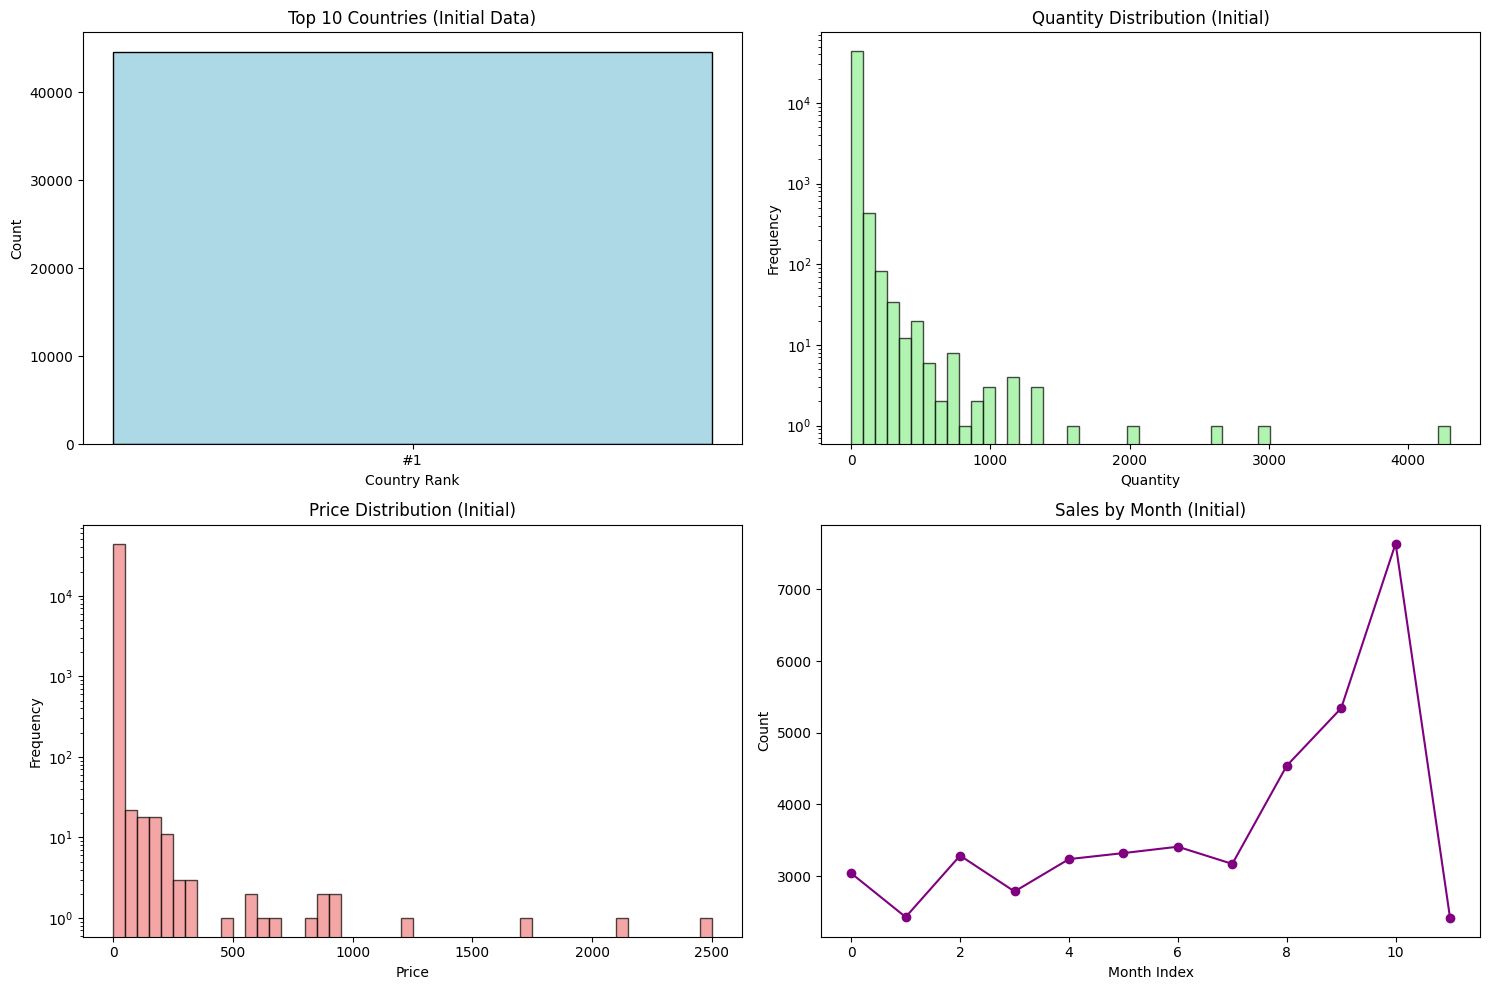


# Filter: Country == 'United Kingdom'
After UK filter: 446861

=== After UK Filter ===


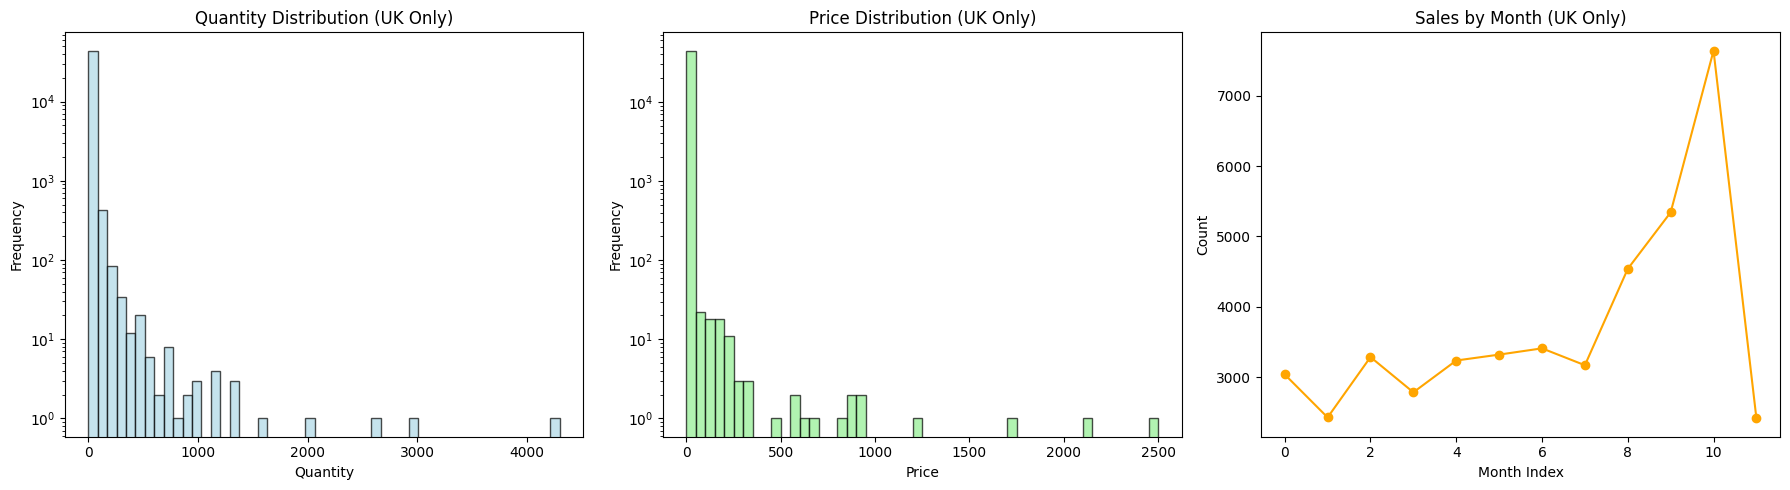


# Remove returns/cancellations
Removed returns (Quantity<0): before=0, after=0

=== Returns Removal Analysis ===


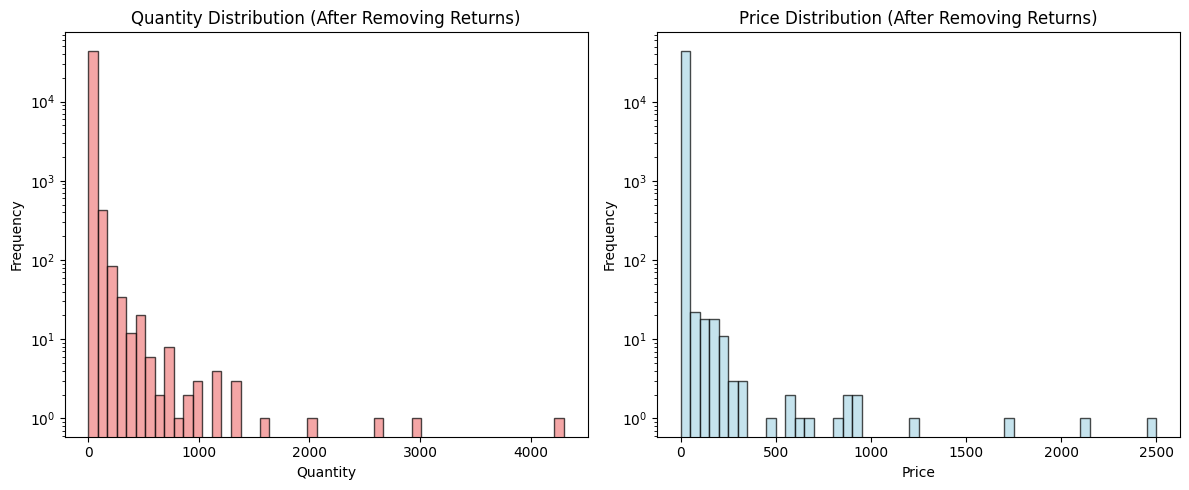


# Drop irrelevant columns
Dropped columns: []

# Using full date range (2009-2011)
Keeping all years in the dataset
Date range: 2011-01-04 10:00:00 to 2011-12-09 12:49:00

=== Final Dataset Overview ===


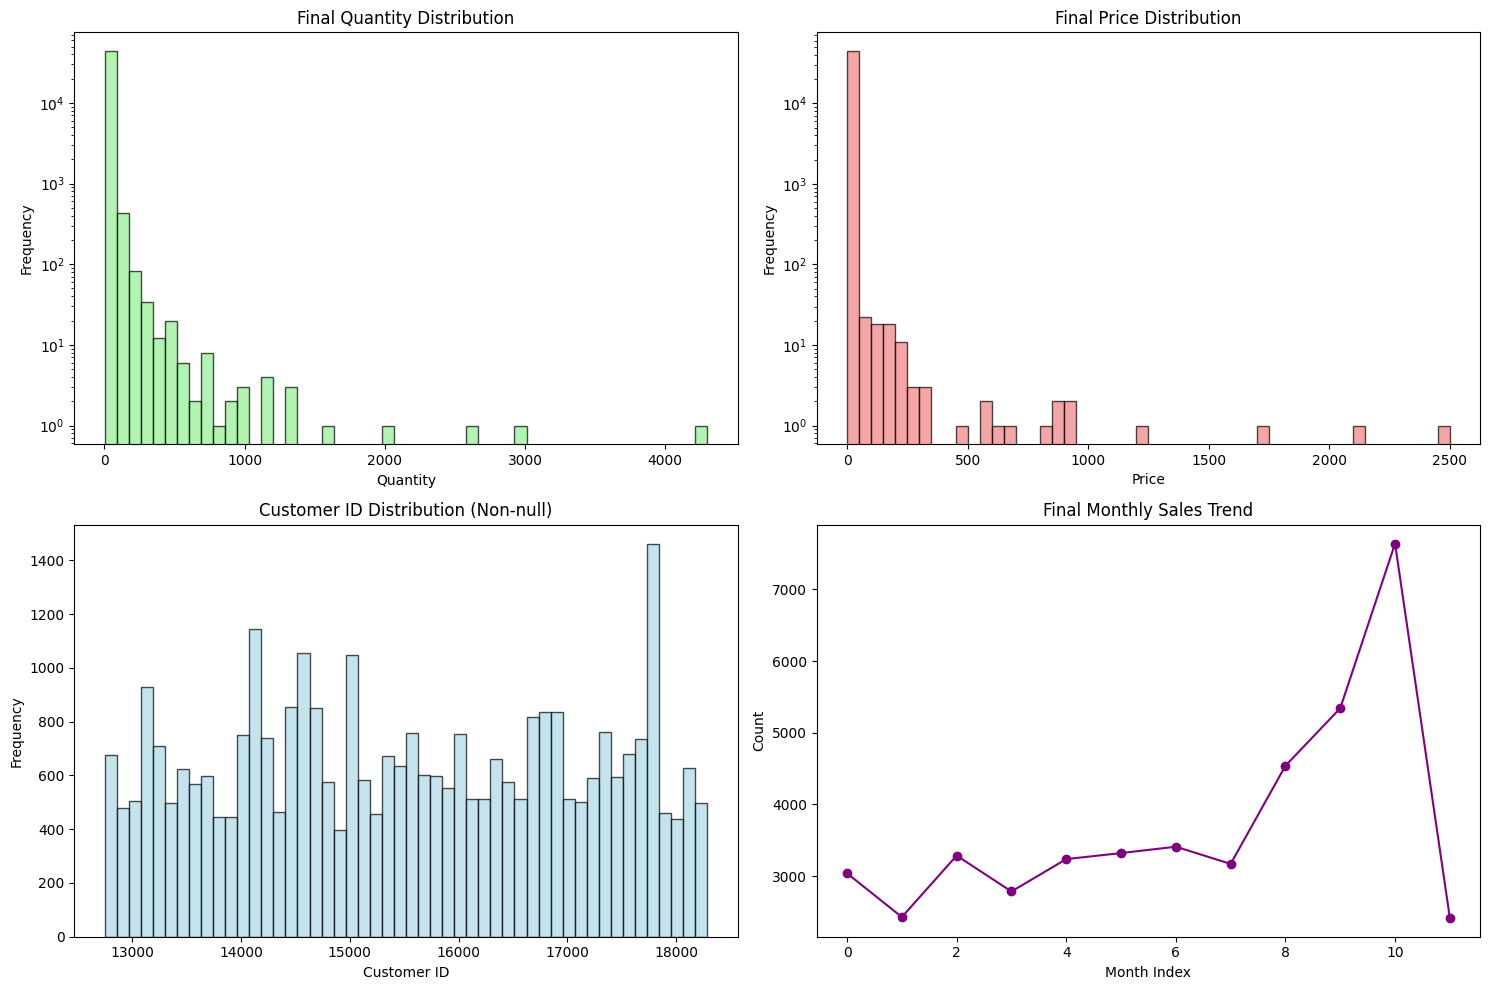


=== Final shape ===
Rows, Columns: 446861 10
+---------+--------+-------------------+-----+-----------+--------------+------------------+------------+------------+---------------+
|StockCode|Quantity|InvoiceDate        |Price|Customer ID|Country       |TotalPrice        |InvoiceMonth|DayOfWeekNum|IsHolidaySeason|
+---------+--------+-------------------+-----+-----------+--------------+------------------+------------+------------+---------------+
|84535A   |6       |2011-04-17 13:43:00|0.65 |15555.0    |United Kingdom|3.9000000000000004|2011-04     |1           |0              |
|22974    |1       |2011-02-18 16:12:00|3.29 |NaN        |United Kingdom|3.29              |2011-02     |6           |0              |
|22749    |1       |2011-09-09 12:22:00|3.75 |18118.0    |United Kingdom|3.75              |2011-09     |6           |0              |
|22698    |1       |2011-08-04 13:51:00|2.95 |14344.0    |United Kingdom|2.95              |2011-08     |5           |0              |
|22965   

In [27]:
# 3.1 Select the Data (PySpark) - Enhanced with Visualizations
from pyspark.sql import functions as F
from pyspark.sql.functions import year
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Start from the current full DataFrame `df`
print("=== Initial shape ===")
init_rows = df.count()
init_cols = len(df.columns)
print(f"Rows, Columns: {init_rows:,}, {init_cols}")

# Visualize initial data distribution
print("\n=== Initial Data Distribution ===")
sample_initial = df.sample(0.1, seed=42).toPandas()

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Country distribution
country_counts = sample_initial['Country'].value_counts().head(10)
axes[0, 0].bar(range(len(country_counts)), country_counts.values, color='lightblue', edgecolor='black')
axes[0, 0].set_title('Top 10 Countries (Initial Data)')
axes[0, 0].set_xlabel('Country Rank')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_xticks(range(len(country_counts)))
axes[0, 0].set_xticklabels([f'#{i+1}' for i in range(len(country_counts))])

# Quantity distribution
axes[0, 1].hist(sample_initial['Quantity'], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0, 1].set_title('Quantity Distribution (Initial)')
axes[0, 1].set_xlabel('Quantity')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_yscale('log')

# Price distribution
axes[1, 0].hist(sample_initial['Price'], bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
axes[1, 0].set_title('Price Distribution (Initial)')
axes[1, 0].set_xlabel('Price')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_yscale('log')

# InvoiceDate distribution (by month)
sample_initial['InvoiceMonth'] = pd.to_datetime(sample_initial['InvoiceDate']).dt.to_period('M')
month_counts = sample_initial['InvoiceMonth'].value_counts().sort_index()
axes[1, 1].plot(range(len(month_counts)), month_counts.values, marker='o', color='purple')
axes[1, 1].set_title('Sales by Month (Initial)')
axes[1, 1].set_xlabel('Month Index')
axes[1, 1].set_ylabel('Count')

plt.tight_layout()
plt.show()

# 1) Filter data to only include United Kingdom transactions
print("\n# Filter: Country == 'United Kingdom'")
df = df.filter(F.col("Country") == "United Kingdom")
uk_count = df.count()
print("After UK filter:", uk_count)

# Visualize UK filter effect
print("\n=== After UK Filter ===")
sample_uk = df.sample(0.1, seed=42).toPandas()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Quantity distribution after UK filter
axes[0].hist(sample_uk['Quantity'], bins=50, alpha=0.7, color='lightblue', edgecolor='black')
axes[0].set_title('Quantity Distribution (UK Only)')
axes[0].set_xlabel('Quantity')
axes[0].set_ylabel('Frequency')
axes[0].set_yscale('log')

# Price distribution after UK filter
axes[1].hist(sample_uk['Price'], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
axes[1].set_title('Price Distribution (UK Only)')
axes[1].set_xlabel('Price')
axes[1].set_ylabel('Frequency')
axes[1].set_yscale('log')

# Monthly sales after UK filter
sample_uk['InvoiceMonth'] = pd.to_datetime(sample_uk['InvoiceDate']).dt.to_period('M')
month_counts_uk = sample_uk['InvoiceMonth'].value_counts().sort_index()
axes[2].plot(range(len(month_counts_uk)), month_counts_uk.values, marker='o', color='orange')
axes[2].set_title('Sales by Month (UK Only)')
axes[2].set_xlabel('Month Index')
axes[2].set_ylabel('Count')

plt.tight_layout()
plt.show()

# 2) Remove all returned/cancelled transactions
print("\n# Remove returns/cancellations")
if "Invoice" in df.columns:
    df = df.filter(~F.col("Invoice").startswith("C"))
elif "InvoiceNo" in df.columns:
    df = df.filter(~F.col("InvoiceNo").startswith("C"))
else:
    print("Warning: No Invoice/InvoiceNo column found; cannot filter cancellations")

# Remove negative quantities
before_neg = df.filter(F.col("Quantity") < 0).count()
df = df.filter(F.col("Quantity") >= 0)
after_neg = df.filter(F.col("Quantity") < 0).count()
print(f"Removed returns (Quantity<0): before={before_neg:,}, after={after_neg:,}")

# Visualize returns removal
print("\n=== Returns Removal Analysis ===")
sample_clean = df.sample(0.1, seed=42).toPandas()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Quantity distribution after removing returns
axes[0].hist(sample_clean['Quantity'], bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
axes[0].set_title('Quantity Distribution (After Removing Returns)')
axes[0].set_xlabel('Quantity')
axes[0].set_ylabel('Frequency')
axes[0].set_yscale('log')

# Price distribution after removing returns
axes[1].hist(sample_clean['Price'], bins=50, alpha=0.7, color='lightblue', edgecolor='black')
axes[1].set_title('Price Distribution (After Removing Returns)')
axes[1].set_xlabel('Price')
axes[1].set_ylabel('Frequency')
axes[1].set_yscale('log')

plt.tight_layout()
plt.show()

# 3) Drop fields not needed for modeling
print("\n# Drop irrelevant columns")
drop_cols = []
for c in ["InvoiceNo", "Invoice", "Description"]:
    if c in df.columns:
        drop_cols.append(c)
if drop_cols:
    df = df.drop(*drop_cols)
print("Dropped columns:", drop_cols)

# 4) Use full date range (2009-2011) - FIXED
print("\n# Using full date range (2009-2011)")
print("Keeping all years in the dataset")

# Show date range to verify
try:
    date_range = df.select(F.min("InvoiceDate").alias("minDate"), F.max("InvoiceDate").alias("maxDate")).collect()[0]
    print(f"Date range: {date_range['minDate']} to {date_range['maxDate']}")
except Exception as e:
    print("Could not determine date range:", e)

# Final visualization
print("\n=== Final Dataset Overview ===")
sample_final = df.sample(0.1, seed=42).toPandas()

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Final quantity distribution
axes[0, 0].hist(sample_final['Quantity'], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0, 0].set_title('Final Quantity Distribution')
axes[0, 0].set_xlabel('Quantity')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_yscale('log')

# Final price distribution
axes[0, 1].hist(sample_final['Price'], bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
axes[0, 1].set_title('Final Price Distribution')
axes[0, 1].set_xlabel('Price')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_yscale('log')

# Customer ID distribution (non-null)
customer_sample = sample_final[sample_final['Customer ID'].notna()]
axes[1, 0].hist(customer_sample['Customer ID'], bins=50, alpha=0.7, color='lightblue', edgecolor='black')
axes[1, 0].set_title('Customer ID Distribution (Non-null)')
axes[1, 0].set_xlabel('Customer ID')
axes[1, 0].set_ylabel('Frequency')

# Monthly sales trend
sample_final['InvoiceMonth'] = pd.to_datetime(sample_final['InvoiceDate']).dt.to_period('M')
month_counts_final = sample_final['InvoiceMonth'].value_counts().sort_index()
axes[1, 1].plot(range(len(month_counts_final)), month_counts_final.values, marker='o', color='purple')
axes[1, 1].set_title('Final Monthly Sales Trend')
axes[1, 1].set_xlabel('Month Index')
axes[1, 1].set_ylabel('Count')

plt.tight_layout()
plt.show()

# Final shape and quick preview
print("\n=== Final shape ===")
print("Rows, Columns:", df.count(), len(df.columns))
df.show(5, truncate=False)


## 3.2 Data Cleaning

Apply cleaning steps aligned with the analysis rationale: drop/impute missing IDs (if chosen), remove cancellations/returns to focus on actual sales, optionally remove extreme outliers, and perform light text tidying.


=== Data Cleaning Start ===

=== Before Cleaning Analysis ===


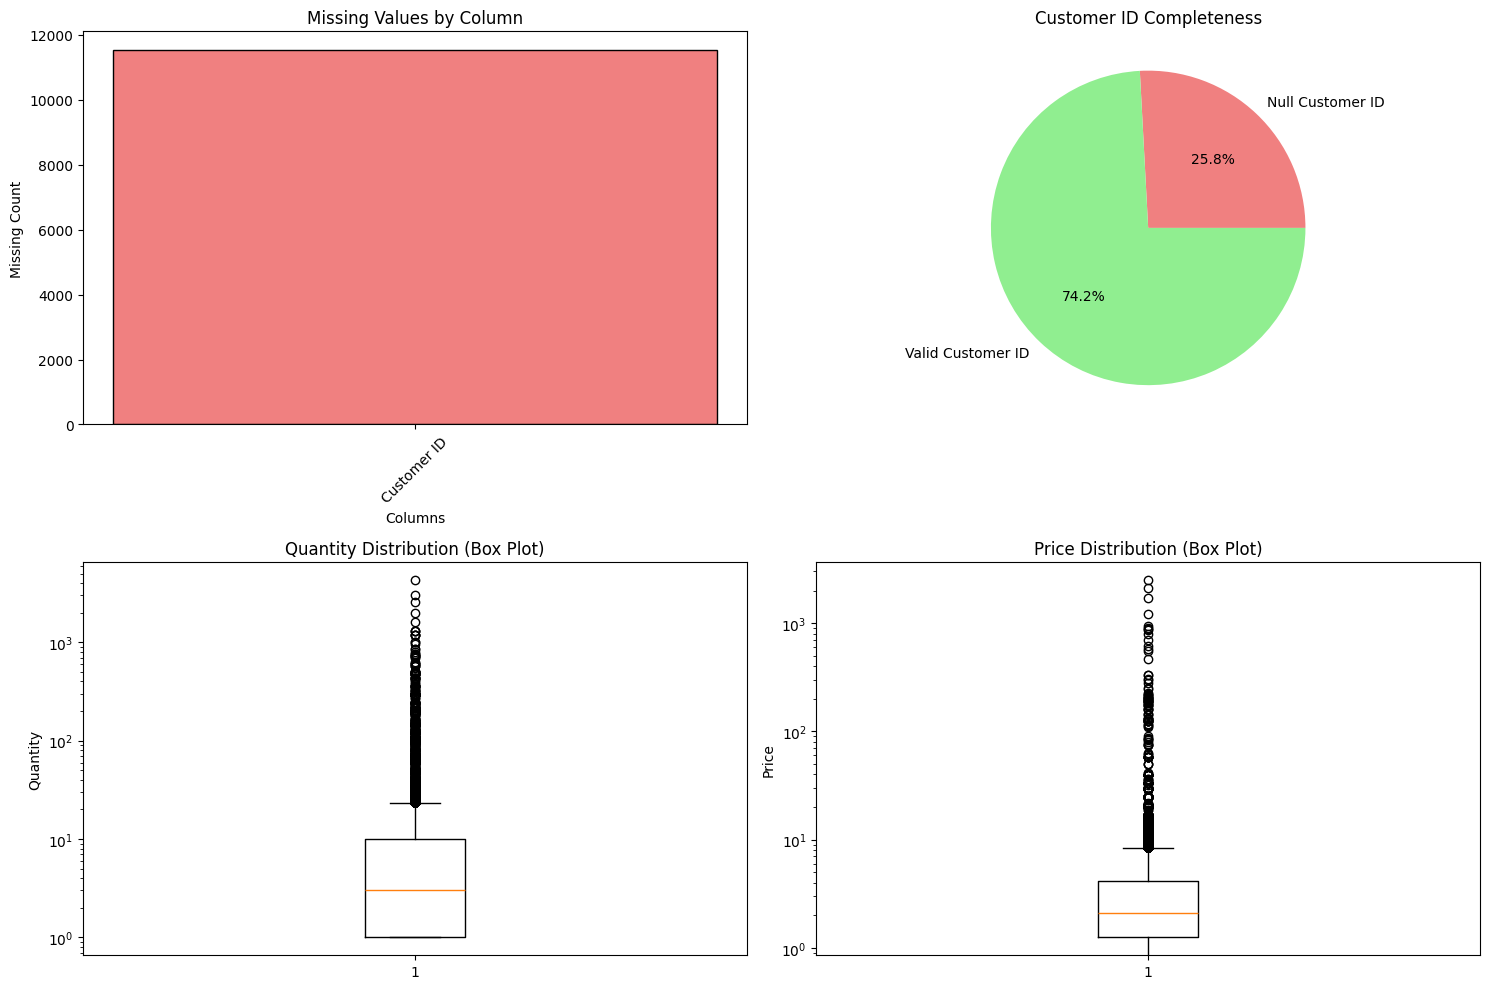


# Remove null Customer ID
Removed null Customer ID: before=0, after=0

# Remove cancelled orders/returns
Removed negative quantities: before=0, after=0

# Remove outliers (optional)
Analyzing outliers...
Quantity IQR bounds: [-12.50, 23.50]
Quantity outliers found: 43,225

=== After Cleaning Analysis ===


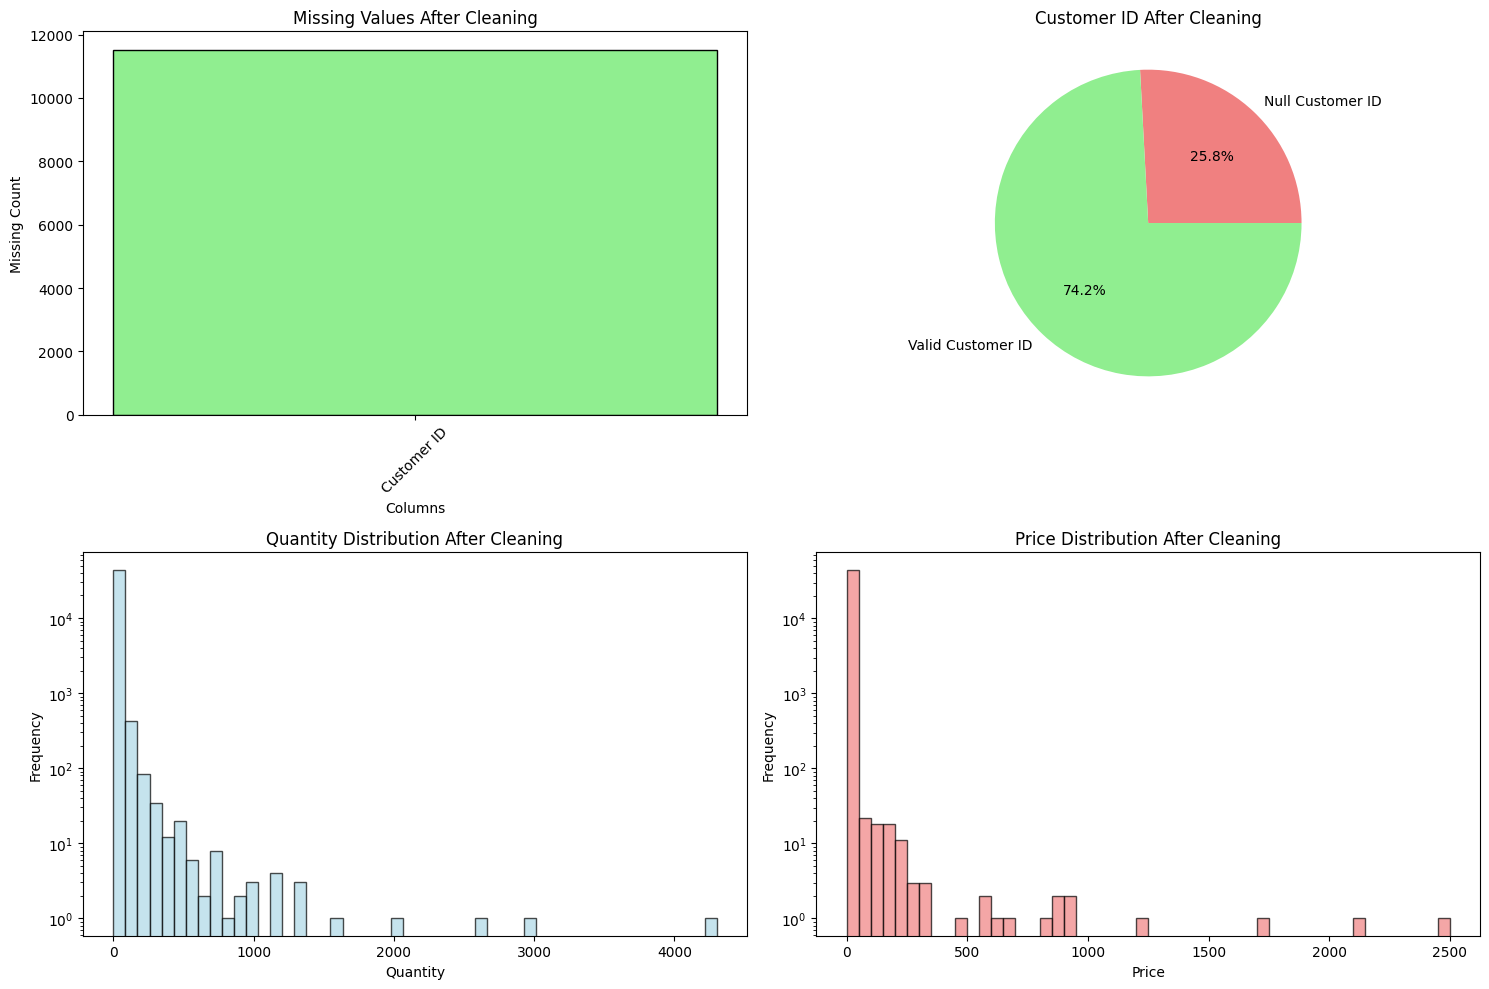


=== Data Quality Summary ===
Final dataset size: 446,861 records
Remaining null Customer IDs: 0
Remaining negative quantities: 0
Records with zero/negative price: 962

Data types:
root
 |-- StockCode: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- Price: double (nullable = true)
 |-- Customer ID: double (nullable = true)
 |-- Country: string (nullable = true)
 |-- TotalPrice: double (nullable = true)
 |-- InvoiceMonth: string (nullable = true)
 |-- DayOfWeekNum: integer (nullable = true)
 |-- IsHolidaySeason: integer (nullable = false)

=== Data Cleaning Complete ===


In [28]:
# 3.2 Data Cleaning (PySpark) - Enhanced with Visualizations
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

print("=== Data Cleaning Start ===")

# Visualize data before cleaning
print("\n=== Before Cleaning Analysis ===")
sample_before = df.sample(0.1, seed=42).toPandas()

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Missing values visualization
missing_counts = sample_before.isnull().sum()
missing_counts = missing_counts[missing_counts > 0]
if len(missing_counts) > 0:
    axes[0, 0].bar(range(len(missing_counts)), missing_counts.values, color='lightcoral', edgecolor='black')
    axes[0, 0].set_title('Missing Values by Column')
    axes[0, 0].set_xlabel('Columns')
    axes[0, 0].set_ylabel('Missing Count')
    axes[0, 0].set_xticks(range(len(missing_counts)))
    axes[0, 0].set_xticklabels(missing_counts.index, rotation=45)
else:
    axes[0, 0].text(0.5, 0.5, 'No Missing Values', ha='center', va='center', transform=axes[0, 0].transAxes)
    axes[0, 0].set_title('Missing Values Check')

# Customer ID null analysis
customer_null_count = sample_before['Customer ID'].isnull().sum()
customer_total = len(sample_before)
axes[0, 1].pie([customer_null_count, customer_total - customer_null_count],
               labels=['Null Customer ID', 'Valid Customer ID'],
               colors=['lightcoral', 'lightgreen'], autopct='%1.1f%%')
axes[0, 1].set_title('Customer ID Completeness')

# Quantity outliers (box plot)
axes[1, 0].boxplot(sample_before['Quantity'], vert=True)
axes[1, 0].set_title('Quantity Distribution (Box Plot)')
axes[1, 0].set_ylabel('Quantity')
axes[1, 0].set_yscale('log')

# Price outliers (box plot)
axes[1, 1].boxplot(sample_before['Price'], vert=True)
axes[1, 1].set_title('Price Distribution (Box Plot)')
axes[1, 1].set_ylabel('Price')
axes[1, 1].set_yscale('log')

plt.tight_layout()
plt.show()

# 1) Remove null Customer ID
print("\n# Remove null Customer ID")
before_customer_null = df.filter(F.col("Customer ID").isNull()).count()
df = df.filter(F.col("Customer ID").isNotNull())
after_customer_null = df.filter(F.col("Customer ID").isNull()).count()
print(f"Removed null Customer ID: before={before_customer_null:,}, after={after_customer_null:,}")

# 2) Remove cancelled orders/returns (if not already done)
print("\n# Remove cancelled orders/returns")
if "Invoice" in df.columns:
    cancelled_before = df.filter(F.col("Invoice").startswith("C")).count()
    df = df.filter(~F.col("Invoice").startswith("C"))
    cancelled_after = df.filter(F.col("Invoice").startswith("C")).count()
    print(f"Removed cancelled orders: before={cancelled_before:,}, after={cancelled_after:,}")

# Remove negative quantities
negative_before = df.filter(F.col("Quantity") < 0).count()
df = df.filter(F.col("Quantity") >= 0)
negative_after = df.filter(F.col("Quantity") < 0).count()
print(f"Removed negative quantities: before={negative_before:,}, after={negative_after:,}")

# 3) Remove outliers (optional)
print("\n# Remove outliers (optional)")
print("Analyzing outliers...")

# Calculate IQR for Quantity
quantity_stats = df.select(F.expr("percentile_approx(Quantity, 0.25)").alias("Q1"),
                           F.expr("percentile_approx(Quantity, 0.75)").alias("Q3")).collect()[0]
Q1, Q3 = quantity_stats["Q1"], quantity_stats["Q3"]
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Quantity IQR bounds: [{lower_bound:.2f}, {upper_bound:.2f}]")

# Count outliers
outliers_before = df.filter((F.col("Quantity") < lower_bound) | (F.col("Quantity") > upper_bound)).count()
print(f"Quantity outliers found: {outliers_before:,}")

# Optional: Remove outliers (uncomment if needed)
# df = df.filter((F.col("Quantity") >= lower_bound) & (F.col("Quantity") <= upper_bound))
# outliers_after = df.filter((F.col("Quantity") < lower_bound) | (F.col("Quantity") > upper_bound)).count()
# print(f"After removing outliers: {outliers_after:,}")

# Visualize cleaning effects
print("\n=== After Cleaning Analysis ===")
sample_after = df.sample(0.1, seed=42).toPandas()

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Missing values after cleaning
missing_counts_after = sample_after.isnull().sum()
missing_counts_after = missing_counts_after[missing_counts_after > 0]
if len(missing_counts_after) > 0:
    axes[0, 0].bar(range(len(missing_counts_after)), missing_counts_after.values, color='lightgreen', edgecolor='black')
    axes[0, 0].set_title('Missing Values After Cleaning')
    axes[0, 0].set_xlabel('Columns')
    axes[0, 0].set_ylabel('Missing Count')
    axes[0, 0].set_xticks(range(len(missing_counts_after)))
    axes[0, 0].set_xticklabels(missing_counts_after.index, rotation=45)
else:
    axes[0, 0].text(0.5, 0.5, 'No Missing Values', ha='center', va='center', transform=axes[0, 0].transAxes)
    axes[0, 0].set_title('Missing Values After Cleaning')

# Customer ID completeness after cleaning
customer_null_after = sample_after['Customer ID'].isnull().sum()
customer_total_after = len(sample_after)
axes[0, 1].pie([customer_null_after, customer_total_after - customer_null_after],
               labels=['Null Customer ID', 'Valid Customer ID'],
               colors=['lightcoral', 'lightgreen'], autopct='%1.1f%%')
axes[0, 1].set_title('Customer ID After Cleaning')

# Quantity distribution after cleaning
axes[1, 0].hist(sample_after['Quantity'], bins=50, alpha=0.7, color='lightblue', edgecolor='black')
axes[1, 0].set_title('Quantity Distribution After Cleaning')
axes[1, 0].set_xlabel('Quantity')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_yscale('log')

# Price distribution after cleaning
axes[1, 1].hist(sample_after['Price'], bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
axes[1, 1].set_title('Price Distribution After Cleaning')
axes[1, 1].set_xlabel('Price')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_yscale('log')

plt.tight_layout()
plt.show()

# 4) Data quality summary
print("\n=== Data Quality Summary ===")
final_count = df.count()
print(f"Final dataset size: {final_count:,} records")

# Check for any remaining issues
remaining_nulls = df.filter(F.col("Customer ID").isNull()).count()
remaining_negative = df.filter(F.col("Quantity") < 0).count()
remaining_zero_price = df.filter(F.col("Price") <= 0).count()

print(f"Remaining null Customer IDs: {remaining_nulls:,}")
print(f"Remaining negative quantities: {remaining_negative:,}")
print(f"Records with zero/negative price: {remaining_zero_price:,}")

# Data type verification
print("\nData types:")
df.printSchema()

print("=== Data Cleaning Complete ===")


## 3.3 Feature Engineering

Engineer transaction-level and product-level features to support downstream modeling and risk analysis.


=== Feature Engineering Start ===
Current DataFrame columns: ['StockCode', 'Quantity', 'InvoiceDate', 'Price', 'Customer ID', 'Country', 'TotalPrice', 'InvoiceMonth', 'DayOfWeekNum', 'IsHolidaySeason']
DataFrame schema:
root
 |-- StockCode: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- Price: double (nullable = true)
 |-- Customer ID: double (nullable = true)
 |-- Country: string (nullable = true)
 |-- TotalPrice: double (nullable = true)
 |-- InvoiceMonth: string (nullable = true)
 |-- DayOfWeekNum: integer (nullable = true)
 |-- IsHolidaySeason: integer (nullable = false)


=== Original Features Analysis ===


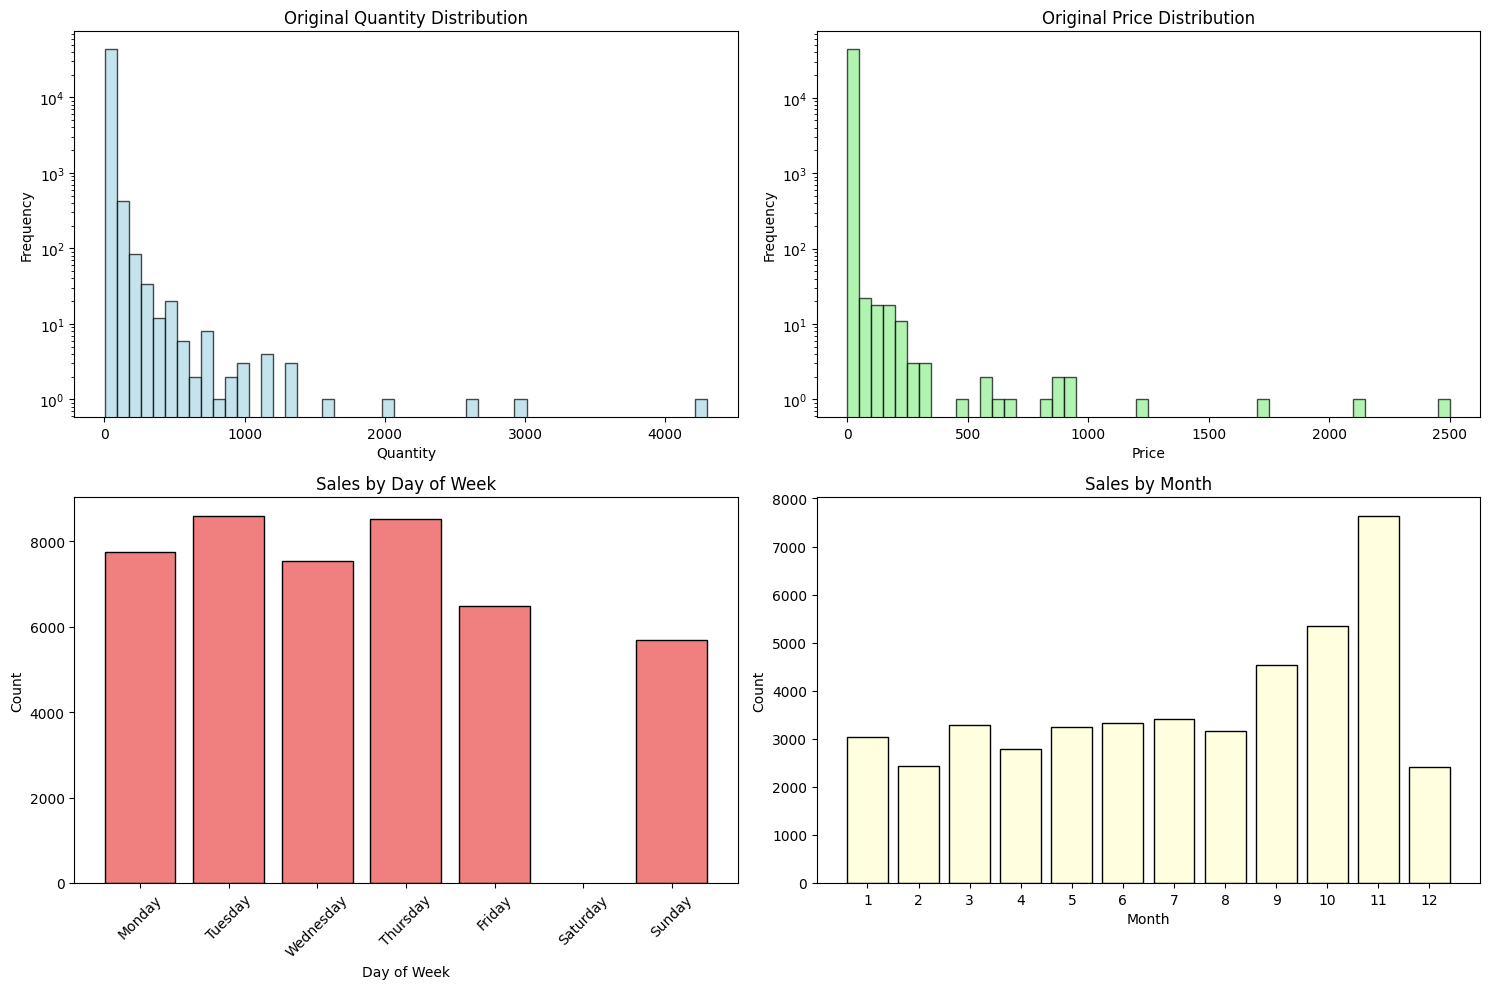

Added: TotalPrice, InvoiceMonth, DayOfWeekNum, IsHolidaySeason

=== Engineered Features Analysis ===


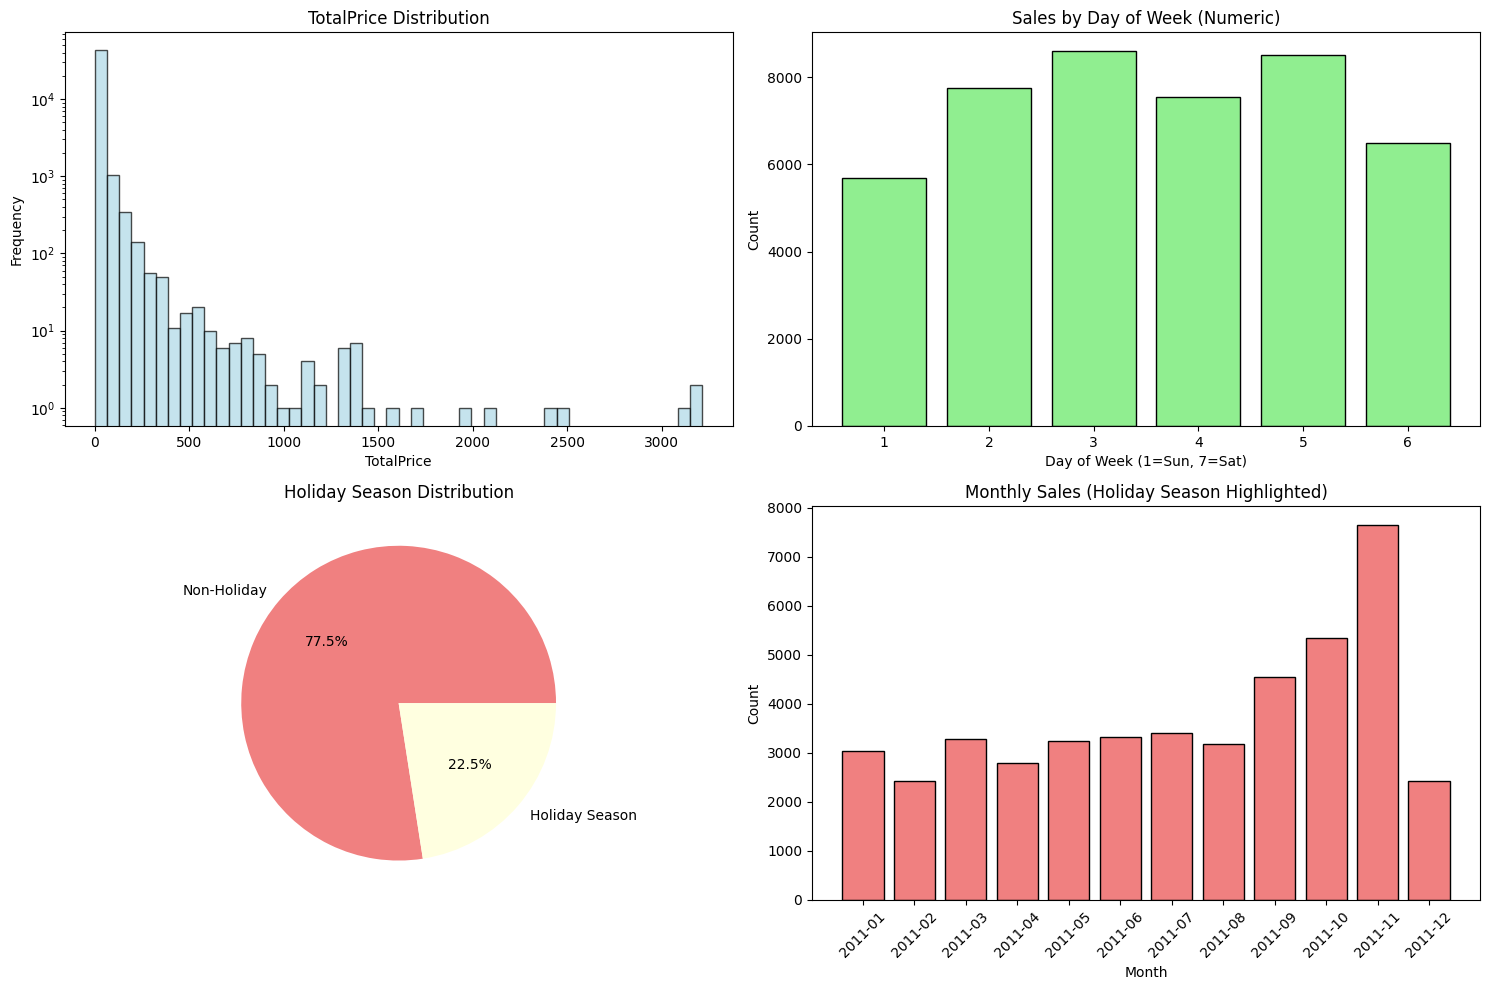


=== Product-Level Aggregation ===
Looking for invoice column in: ['StockCode', 'Quantity', 'InvoiceDate', 'Price', 'Customer ID', 'Country', 'TotalPrice', 'InvoiceMonth', 'DayOfWeekNum', 'IsHolidaySeason']
Found invoice column: InvoiceDate
Product-level features computed: TotalQuantity, NumInvoices, TotalRevenue, First/LastSaleDate

=== Product-Level Features Analysis ===


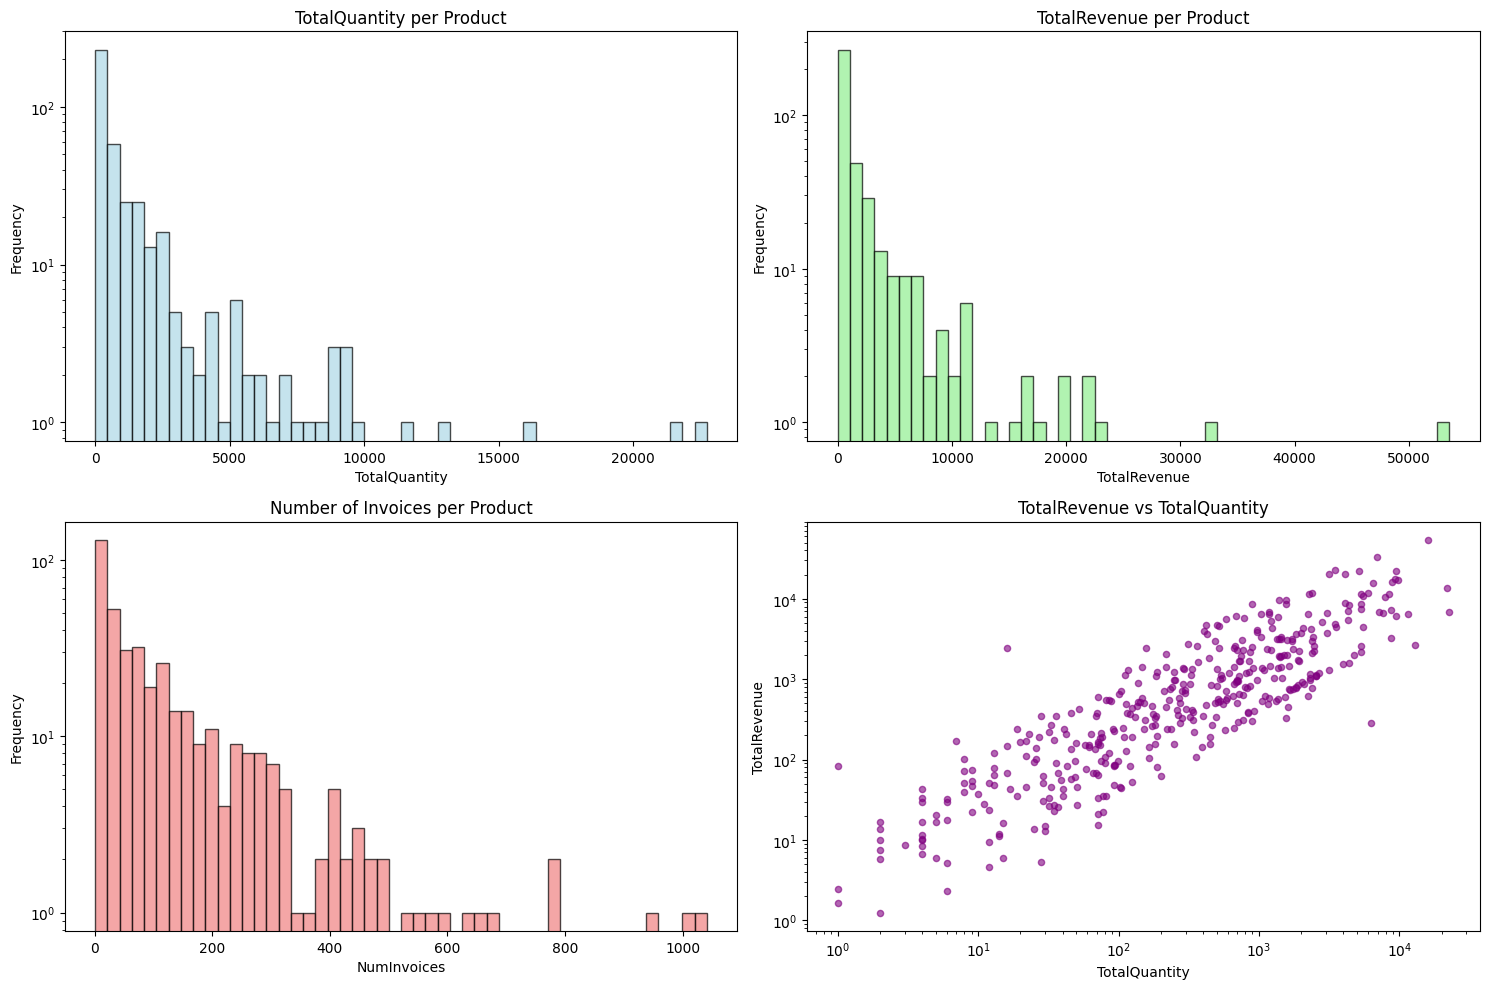

Added: DaysSinceLastSale (recency)
Added: WasteRisk (1 = low sales & no sale in >180 days)

=== Final Features with WasteRisk Analysis ===


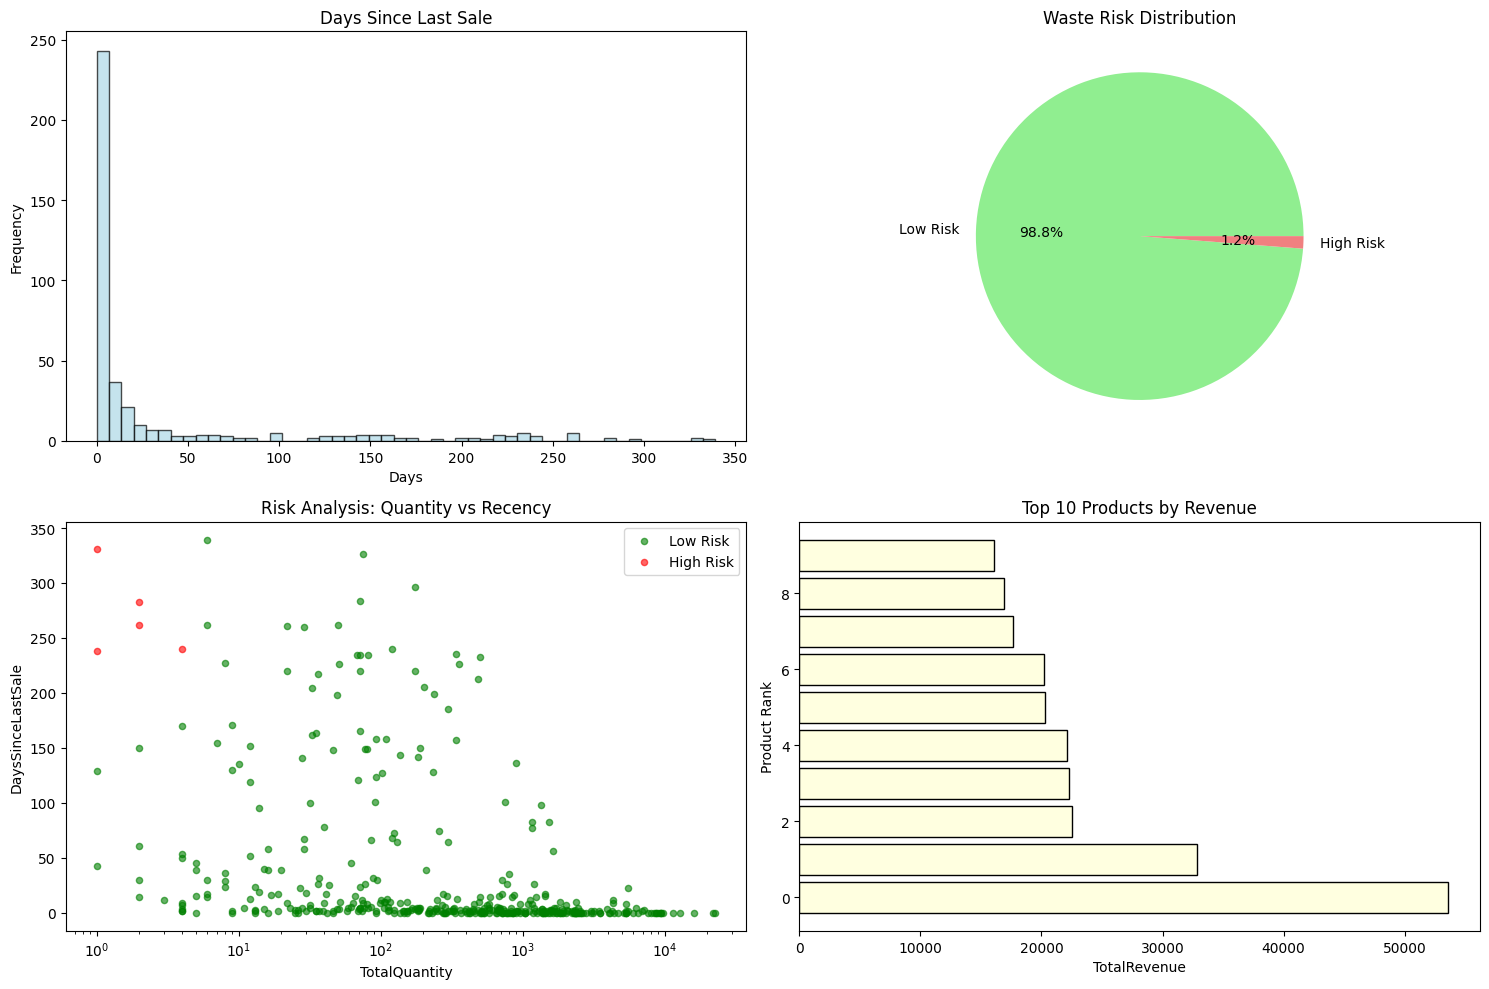


Sample transaction-level features:
+---------+-----+--------+------------------+-------------------+------------+------------+---------------+
|StockCode|Price|Quantity|TotalPrice        |InvoiceDate        |InvoiceMonth|DayOfWeekNum|IsHolidaySeason|
+---------+-----+--------+------------------+-------------------+------------+------------+---------------+
|84535A   |0.65 |6       |3.9000000000000004|2011-04-17 13:43:00|2011-04     |1           |0              |
|22974    |3.29 |1       |3.29              |2011-02-18 16:12:00|2011-02     |6           |0              |
|22749    |3.75 |1       |3.75              |2011-09-09 12:22:00|2011-09     |6           |0              |
|22698    |2.95 |1       |2.95              |2011-08-04 13:51:00|2011-08     |5           |0              |
|22965    |1.85 |48      |88.80000000000001 |2011-07-28 15:20:00|2011-07     |5           |0              |
+---------+-----+--------+------------------+-------------------+------------+------------+---------

In [29]:
# 3.3 Feature Engineering (PySpark) - Enhanced with Visualizations
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

print("=== Feature Engineering Start ===")

# Debug: Check current DataFrame columns
print(f"Current DataFrame columns: {df.columns}")
print(f"DataFrame schema:")
df.printSchema()

# Visualize original features before engineering
print("\n=== Original Features Analysis ===")
sample_original = df.sample(0.1, seed=42).toPandas()

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Quantity distribution
axes[0, 0].hist(sample_original['Quantity'], bins=50, alpha=0.7, color='lightblue', edgecolor='black')
axes[0, 0].set_title('Original Quantity Distribution')
axes[0, 0].set_xlabel('Quantity')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_yscale('log')

# Price distribution
axes[0, 1].hist(sample_original['Price'], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0, 1].set_title('Original Price Distribution')
axes[0, 1].set_xlabel('Price')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_yscale('log')

# InvoiceDate distribution (by day of week)
sample_original['DayOfWeek'] = pd.to_datetime(sample_original['InvoiceDate']).dt.day_name()
day_counts = sample_original['DayOfWeek'].value_counts()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_counts = day_counts.reindex(day_order)
axes[1, 0].bar(range(len(day_counts)), day_counts.values, color='lightcoral', edgecolor='black')
axes[1, 0].set_title('Sales by Day of Week')
axes[1, 0].set_xlabel('Day of Week')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_xticks(range(len(day_counts)))
axes[1, 0].set_xticklabels(day_counts.index, rotation=45)

# Monthly sales pattern
sample_original['Month'] = pd.to_datetime(sample_original['InvoiceDate']).dt.month
month_counts = sample_original['Month'].value_counts().sort_index()
axes[1, 1].bar(range(len(month_counts)), month_counts.values, color='lightyellow', edgecolor='black')
axes[1, 1].set_title('Sales by Month')
axes[1, 1].set_xlabel('Month')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_xticks(range(len(month_counts)))
axes[1, 1].set_xticklabels(month_counts.index)

plt.tight_layout()
plt.show()

# 1) TotalPrice of each line (quantity * unit price)
unit_col = "UnitPrice" if "UnitPrice" in df.columns else ("Price" if "Price" in df.columns else None)
if unit_col is None:
    raise ValueError("Neither 'UnitPrice' nor 'Price' column found.")

df = df.withColumn("TotalPrice", F.col("Quantity") * F.col(unit_col))

# 2) Ensure InvoiceDate is timestamp and derive date features
if dict(df.dtypes).get("InvoiceDate") != "timestamp":
    df = df.withColumn("InvoiceDate", F.to_timestamp("InvoiceDate"))

# InvoiceMonth as yyyy-MM string
df = df.withColumn("InvoiceMonth", F.date_format("InvoiceDate", "yyyy-MM"))
# Numeric day of week (1=Sunday ... 7=Saturday)
df = df.withColumn("DayOfWeekNum", F.dayofweek("InvoiceDate"))
# Holiday season flag: November or December
df = df.withColumn("IsHolidaySeason", F.when(F.month("InvoiceDate").isin([11,12]), 1).otherwise(0))

print("Added: TotalPrice, InvoiceMonth, DayOfWeekNum, IsHolidaySeason")

# Visualize engineered features
print("\n=== Engineered Features Analysis ===")
sample_engineered = df.sample(0.1, seed=42).toPandas()

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# TotalPrice distribution
axes[0, 0].hist(sample_engineered['TotalPrice'], bins=50, alpha=0.7, color='lightblue', edgecolor='black')
axes[0, 0].set_title('TotalPrice Distribution')
axes[0, 0].set_xlabel('TotalPrice')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_yscale('log')

# DayOfWeekNum distribution
dayofweek_counts = sample_engineered['DayOfWeekNum'].value_counts().sort_index()
axes[0, 1].bar(range(len(dayofweek_counts)), dayofweek_counts.values, color='lightgreen', edgecolor='black')
axes[0, 1].set_title('Sales by Day of Week (Numeric)')
axes[0, 1].set_xlabel('Day of Week (1=Sun, 7=Sat)')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_xticks(range(len(dayofweek_counts)))
axes[0, 1].set_xticklabels(dayofweek_counts.index)

# Holiday season analysis
holiday_counts = sample_engineered['IsHolidaySeason'].value_counts()
axes[1, 0].pie(holiday_counts.values, labels=['Non-Holiday', 'Holiday Season'],
               colors=['lightcoral', 'lightyellow'], autopct='%1.1f%%')
axes[1, 0].set_title('Holiday Season Distribution')

# Monthly sales with holiday highlighting
month_counts_eng = sample_engineered['InvoiceMonth'].value_counts().sort_index()
colors = ['lightcoral' if '11' in month or '12' in month else 'lightblue' for month in month_counts_eng.index]
axes[1, 1].bar(range(len(month_counts_eng)), month_counts_eng.values, color=colors, edgecolor='black')
axes[1, 1].set_title('Monthly Sales (Holiday Season Highlighted)')
axes[1, 1].set_xlabel('Month')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_xticks(range(len(month_counts_eng)))
axes[1, 1].set_xticklabels(month_counts_eng.index, rotation=45)

plt.tight_layout()
plt.show()

# 3) Product-level aggregation (StockCode)
print("\n=== Product-Level Aggregation ===")
# Debug: Check for invoice column
print(f"Looking for invoice column in: {df.columns}")
invoice_col = None
for col_name in df.columns:
    if "invoice" in col_name.lower():
        invoice_col = col_name
        print(f"Found invoice column: {invoice_col}")
        break

if invoice_col is None:
    raise ValueError(f"No invoice column found. Available columns: {df.columns}")

product_stats = df.groupBy("StockCode").agg(
    F.sum("Quantity").alias("TotalQuantity"),
    F.count_distinct(F.col(invoice_col)).alias("NumInvoices"),
    F.sum("TotalPrice").alias("TotalRevenue"),
    F.min("InvoiceDate").alias("FirstSaleDate"),
    F.max("InvoiceDate").alias("LastSaleDate")
)

print("Product-level features computed: TotalQuantity, NumInvoices, TotalRevenue, First/LastSaleDate")

# Visualize product-level features
print("\n=== Product-Level Features Analysis ===")
sample_products = product_stats.sample(0.1, seed=42).toPandas()

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# TotalQuantity distribution
axes[0, 0].hist(sample_products['TotalQuantity'], bins=50, alpha=0.7, color='lightblue', edgecolor='black')
axes[0, 0].set_title('TotalQuantity per Product')
axes[0, 0].set_xlabel('TotalQuantity')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_yscale('log')

# TotalRevenue distribution
axes[0, 1].hist(sample_products['TotalRevenue'], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0, 1].set_title('TotalRevenue per Product')
axes[0, 1].set_xlabel('TotalRevenue')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_yscale('log')

# NumInvoices distribution
axes[1, 0].hist(sample_products['NumInvoices'], bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
axes[1, 0].set_title('Number of Invoices per Product')
axes[1, 0].set_xlabel('NumInvoices')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_yscale('log')

# Revenue vs Quantity scatter
axes[1, 1].scatter(sample_products['TotalQuantity'], sample_products['TotalRevenue'],
                  alpha=0.6, color='purple', s=20)
axes[1, 1].set_title('TotalRevenue vs TotalQuantity')
axes[1, 1].set_xlabel('TotalQuantity')
axes[1, 1].set_ylabel('TotalRevenue')
axes[1, 1].set_xscale('log')
axes[1, 1].set_yscale('log')

plt.tight_layout()
plt.show()

# 4) Recency: days since last sale (relative to max date in dataset)
max_date = df.agg(F.max("InvoiceDate").alias("maxDate")).collect()[0]["maxDate"]
product_stats = product_stats.withColumn("DaysSinceLastSale", F.datediff(F.lit(max_date), F.col("LastSaleDate")))
print("Added: DaysSinceLastSale (recency)")

# 5) WasteRisk label: low sales and stale recency → high risk
product_stats = product_stats.withColumn(
    "WasteRisk",
    F.when((F.col("TotalQuantity") < 5) & (F.col("DaysSinceLastSale") > 180), 1).otherwise(0)
)
print("Added: WasteRisk (1 = low sales & no sale in >180 days)")

# Visualize final features including WasteRisk
print("\n=== Final Features with WasteRisk Analysis ===")
sample_final = product_stats.sample(0.1, seed=42).toPandas()

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# DaysSinceLastSale distribution
axes[0, 0].hist(sample_final['DaysSinceLastSale'], bins=50, alpha=0.7, color='lightblue', edgecolor='black')
axes[0, 0].set_title('Days Since Last Sale')
axes[0, 0].set_xlabel('Days')
axes[0, 0].set_ylabel('Frequency')

# WasteRisk distribution
waste_counts = sample_final['WasteRisk'].value_counts()
axes[0, 1].pie(waste_counts.values, labels=['Low Risk', 'High Risk'],
               colors=['lightgreen', 'lightcoral'], autopct='%1.1f%%')
axes[0, 1].set_title('Waste Risk Distribution')

# Risk analysis: TotalQuantity vs DaysSinceLastSale
low_risk = sample_final[sample_final['WasteRisk'] == 0]
high_risk = sample_final[sample_final['WasteRisk'] == 1]

axes[1, 0].scatter(low_risk['TotalQuantity'], low_risk['DaysSinceLastSale'],
                  alpha=0.6, color='green', s=20, label='Low Risk')
axes[1, 0].scatter(high_risk['TotalQuantity'], high_risk['DaysSinceLastSale'],
                  alpha=0.6, color='red', s=20, label='High Risk')
axes[1, 0].set_title('Risk Analysis: Quantity vs Recency')
axes[1, 0].set_xlabel('TotalQuantity')
axes[1, 0].set_ylabel('DaysSinceLastSale')
axes[1, 0].set_xscale('log')
axes[1, 0].legend()

# Top products by revenue
top_products = sample_final.nlargest(10, 'TotalRevenue')
axes[1, 1].barh(range(len(top_products)), top_products['TotalRevenue'], color='lightyellow', edgecolor='black')
axes[1, 1].set_title('Top 10 Products by Revenue')
axes[1, 1].set_xlabel('TotalRevenue')
axes[1, 1].set_ylabel('Product Rank')

plt.tight_layout()
plt.show()

# Show sample results
print("\nSample transaction-level features:")
df.select("StockCode", unit_col, "Quantity", "TotalPrice", "InvoiceDate", "InvoiceMonth", "DayOfWeekNum", "IsHolidaySeason").show(5, truncate=False)

print("\nSample product-level features:")
product_stats.select("StockCode", "TotalQuantity", "NumInvoices", "TotalRevenue", "DaysSinceLastSale", "WasteRisk").orderBy(F.desc("TotalQuantity")).show(10, truncate=False)

print("=== Feature Engineering Done ===")


## 3.4 Integrate Various Data Sources

Read and combine multiple files (if any), join extra product information, and verify the integrated dataset.


In [22]:
# 3.4 Integrate Various Data Sources (PySpark)
from pyspark.sql import functions as F

print("=== Data Source Integration ===")

# A) Read and combine multiple files (if provided separately)
#    Example for two yearly CSVs. Commented out by default — uncomment if used.
# df1 = spark.read.csv("online_retail_II_2009_2010.csv", header=True, inferSchema=True)
# df2 = spark.read.csv("online_retail_II_2010_2011.csv", header=True, inferSchema=True)
# df = df1.unionByName(df2)  # Combine two yearly datasets into one DataFrame
# print("After union:", df.count(), "rows |", len(df.columns), "columns")
# df.printSchema()

# B) Join additional product info (e.g., categories) keyed by StockCode
#    Example: join transaction-level df with a product catalog
# product_info = spark.read.csv("product_catalog.csv", header=True, inferSchema=True)
# df = df.join(product_info, on="StockCode", how="left")  # Add product category information by StockCode
# print("After left join with product_info:", df.count(), "rows |", len(df.columns), "columns")

# C) Alternatively, join at product level after aggregation
#    Example: product-level catalog joined to product_stats
# product_catalog = spark.read.csv("product_catalog.csv", header=True, inferSchema=True)
# product_stats = product_stats.join(product_catalog, on="StockCode", how="left")
# print("product_stats columns after join:", product_stats.columns)

# D) Verify combined dataset (min/max date, sample)
try:
	min_max = df.select(F.min("InvoiceDate").alias("minDate"), F.max("InvoiceDate").alias("maxDate")).collect()[0]
	print(f"Date range after integration: {min_max['minDate']} → {min_max['maxDate']}")
except Exception as e:
	print("Date verification skipped:", e)

print("Sample rows:")
df.limit(5).show(truncate=False)

print("=== Integration Section Complete ===")


=== Data Source Integration ===
Date range after integration: 2011-01-04 10:00:00 → 2011-12-09 12:49:00
Sample rows:
+---------+--------+-------------------+-----+-----------+--------------+------------------+------------+------------+---------------+
|StockCode|Quantity|InvoiceDate        |Price|Customer ID|Country       |TotalPrice        |InvoiceMonth|DayOfWeekNum|IsHolidaySeason|
+---------+--------+-------------------+-----+-----------+--------------+------------------+------------+------------+---------------+
|84535A   |6       |2011-04-17 13:43:00|0.65 |15555.0    |United Kingdom|3.9000000000000004|2011-04     |1           |0              |
|22974    |1       |2011-02-18 16:12:00|3.29 |NaN        |United Kingdom|3.29              |2011-02     |6           |0              |
|22749    |1       |2011-09-09 12:22:00|3.75 |18118.0    |United Kingdom|3.75              |2011-09     |6           |0              |
|22698    |1       |2011-08-04 13:51:00|2.95 |14344.0    |United Kingdom|

## 3.5 Format the Data as Required

Convert data types, optionally encode categorical variables, assemble and scale features for modeling, and (optionally) split into train/test sets.


In [23]:
# 3.5 Format the Data as Required (PySpark)
from pyspark.sql import functions as F
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler

print("=== Data Formatting Start ===")

# A) Convert data types (InvoiceDate to timestamp; Quantity to int; UnitPrice to double)
if dict(df.dtypes).get("InvoiceDate") != "timestamp":
	df = df.withColumn("InvoiceDate", F.to_timestamp("InvoiceDate"))

# If fields came as strings, cast them (guard with existence checks)
if dict(df.dtypes).get("Quantity") != "int":
	df = df.withColumn("Quantity", F.col("Quantity").cast("int"))

if "UnitPrice" in df.columns and dict(df.dtypes).get("UnitPrice") != "double":
	df = df.withColumn("UnitPrice", F.col("UnitPrice").cast("double"))
elif "Price" in df.columns and dict(df.dtypes).get("Price") != "double":
	df = df.withColumn("Price", F.col("Price").cast("double"))

print("Schema after type fixes:")
df.printSchema()

# B) (Optional) Encode categorical variables
# Example: Country (if retained) → index + one-hot (commented out by default)
# if "Country" in df.columns:
# 	indexer = StringIndexer(inputCol="Country", outputCol="CountryIndex", handleInvalid="keep")
# 	df_indexed = indexer.fit(df).transform(df)
# 	encoder = OneHotEncoder(inputCol="CountryIndex", outputCol="CountryVec")
# 	df = encoder.fit(df_indexed).transform(df_indexed)
# 	print("Added encoded Country features (CountryIndex, CountryVec)")

# C) Assemble and scale product-level features (for modeling)
#    Use product_stats created in Feature Engineering
assembler = VectorAssembler(
	inputCols=["TotalQuantity", "TotalRevenue", "DaysSinceLastSale"],
	outputCol="features"
)
product_vector_df = assembler.transform(product_stats)

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withMean=True, withStd=True)
scalerModel = scaler.fit(product_vector_df)
product_scaled_df = scalerModel.transform(product_vector_df)

print("Sample scaled features:")
product_scaled_df.select("StockCode", "features", "scaledFeatures", "WasteRisk").show(5, truncate=False)

# D) (Optional) Split into train/test sets for modeling
train_df, test_df = product_scaled_df.randomSplit([0.8, 0.2], seed=42)
print(f"Train size: {train_df.count()} | Test size: {test_df.count()}")

print(f"Final product dataset count: {product_stats.count()} products")
product_stats.select("StockCode","TotalQuantity","WasteRisk").show(5, truncate=False)

print("=== Data Formatting Done ===")


=== Data Formatting Start ===
Schema after type fixes:
root
 |-- StockCode: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- Price: double (nullable = true)
 |-- Customer ID: double (nullable = true)
 |-- Country: string (nullable = true)
 |-- TotalPrice: double (nullable = true)
 |-- InvoiceMonth: string (nullable = true)
 |-- DayOfWeekNum: integer (nullable = true)
 |-- IsHolidaySeason: integer (nullable = false)

Sample scaled features:
+---------+-------------------------------+-----------------------------------------------------------+---------+
|StockCode|features                       |scaledFeatures                                             |WasteRisk|
+---------+-------------------------------+-----------------------------------------------------------+---------+
|21259    |[889.0,5414.460000000005,0.0]  |[-0.08426892383824225,0.487547497745264,-0.503791827732986]|0        |
|23318    |[3223.0,7841.03000000

# 4. Data transformation

## 4.1 Reduce the Data

Drop redundant features, optionally apply PCA to reduce dimensionality, and (optionally) sample for quick prototyping. Show the effect after reduction.


In [24]:
# 4.1 Reduce the Data (PySpark)
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import PCA as PCAml

print("=== Data Reduction Start ===")

# A) Feature selection: drop redundant/less-informative columns
#    Example: drop NumInvoices if highly correlated with TotalQuantity
if "NumInvoices" in product_stats.columns:
	product_stats = product_stats.drop("NumInvoices")
	print("Dropped feature: NumInvoices (assumed correlated with TotalQuantity)")

print("Remaining features in product_stats:", product_stats.columns)

# B) (Optional) PCA to reduce dimensionality
#    Assemble selected numeric features into a vector for PCA
pca_input_cols = ["TotalQuantity", "TotalRevenue", "DaysSinceLastSale"]
assembler = VectorAssembler(inputCols=pca_input_cols, outputCol="featVec")
prod_vec = assembler.transform(product_stats)

# Keep 2 principal components (adjust k as needed)
pca = PCAml(k=2, inputCol="featVec", outputCol="pcaFeatures")
pca_model = pca.fit(prod_vec)
prod_pca = pca_model.transform(prod_vec)

print("Explained variance by PCs:", pca_model.explainedVariance.toArray())
print("Example pcaFeatures:")
prod_pca.select("StockCode", "pcaFeatures", "WasteRisk").show(5, truncate=False)

# C) (Optional) Sampling for quick prototyping
# sample_df = product_stats.sample(withReplacement=False, fraction=0.5, seed=1)
# print(f"Sample size (50%): {sample_df.count()}")

print(f"Number of products considered: {product_stats.count()}")
print("=== Data Reduction Done ===")


=== Data Reduction Start ===
Dropped feature: NumInvoices (assumed correlated with TotalQuantity)
Remaining features in product_stats: ['StockCode', 'TotalQuantity', 'TotalRevenue', 'FirstSaleDate', 'LastSaleDate', 'DaysSinceLastSale', 'WasteRisk']
Explained variance by PCs: [0.91612667 0.08376756]
Example pcaFeatures:
+---------+-----------------------------------------+---------+
|StockCode|pcaFeatures                              |WasteRisk|
+---------+-----------------------------------------+---------+
|21259    |[-5394.407793821097,-1003.5053444507757] |0        |
|23318    |[-8469.618603774783,367.19089151787557]  |0        |
|21889    |[-7691.233083646227,2073.133018912361]   |0        |
|22596    |[-4893.876872665939,1786.518184236199]   |0        |
|22728    |[-15633.742960688607,-1476.5816220601153]|0        |
+---------+-----------------------------------------+---------+
only showing top 5 rows

Number of products considered: 3831
=== Data Reduction Done ===


## 4.2 Project the Data

Apply advanced projections/transformations (PCA, logs, interactions, optional clustering) to prepare data for modeling or visualization.


=== Data Projection Start ===
Explained variance by 3 PCs: [9.16005255e-01 8.39007600e-02 9.39845615e-05]
+----------------------------------------------------------+
|pcaFeatures                                               |
+----------------------------------------------------------+
|[-404.01187164919594,358.6212557183174,236.38701088158527]|
|[-279.88921025392756,425.2280580760776,19.353467603524685]|
|[-3.4338407536686715,2.318515385251368,253.01105356107826]|
|[-8.763096732733436,9.505944831275459,33.03402410420965]  |
|[-8.763096732733436,9.505944831275459,33.03402410420965]  |
+----------------------------------------------------------+
only showing top 5 rows


=== Log Transformation Analysis ===
Sampling data for visualization...


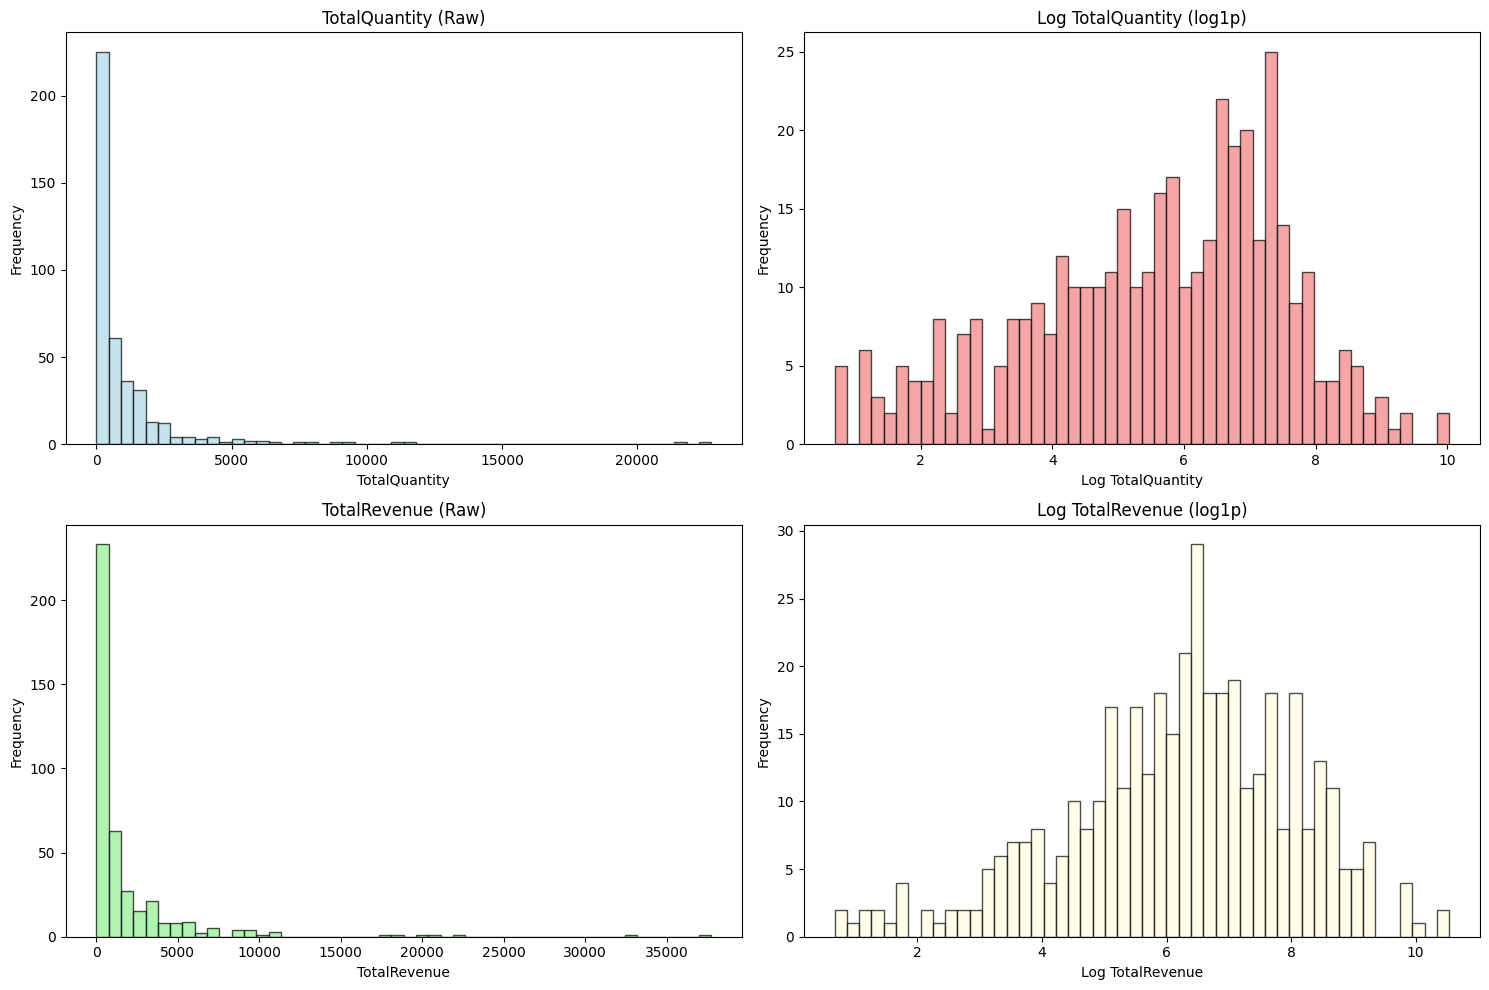

Added LogTotalSales and LogTotalRevenue (log1p transformations)
Added Revenue_x_Recency interaction feature
KMeans demo skipped: Output column featVec already exists.

=== Feature Scaling Comparison ===


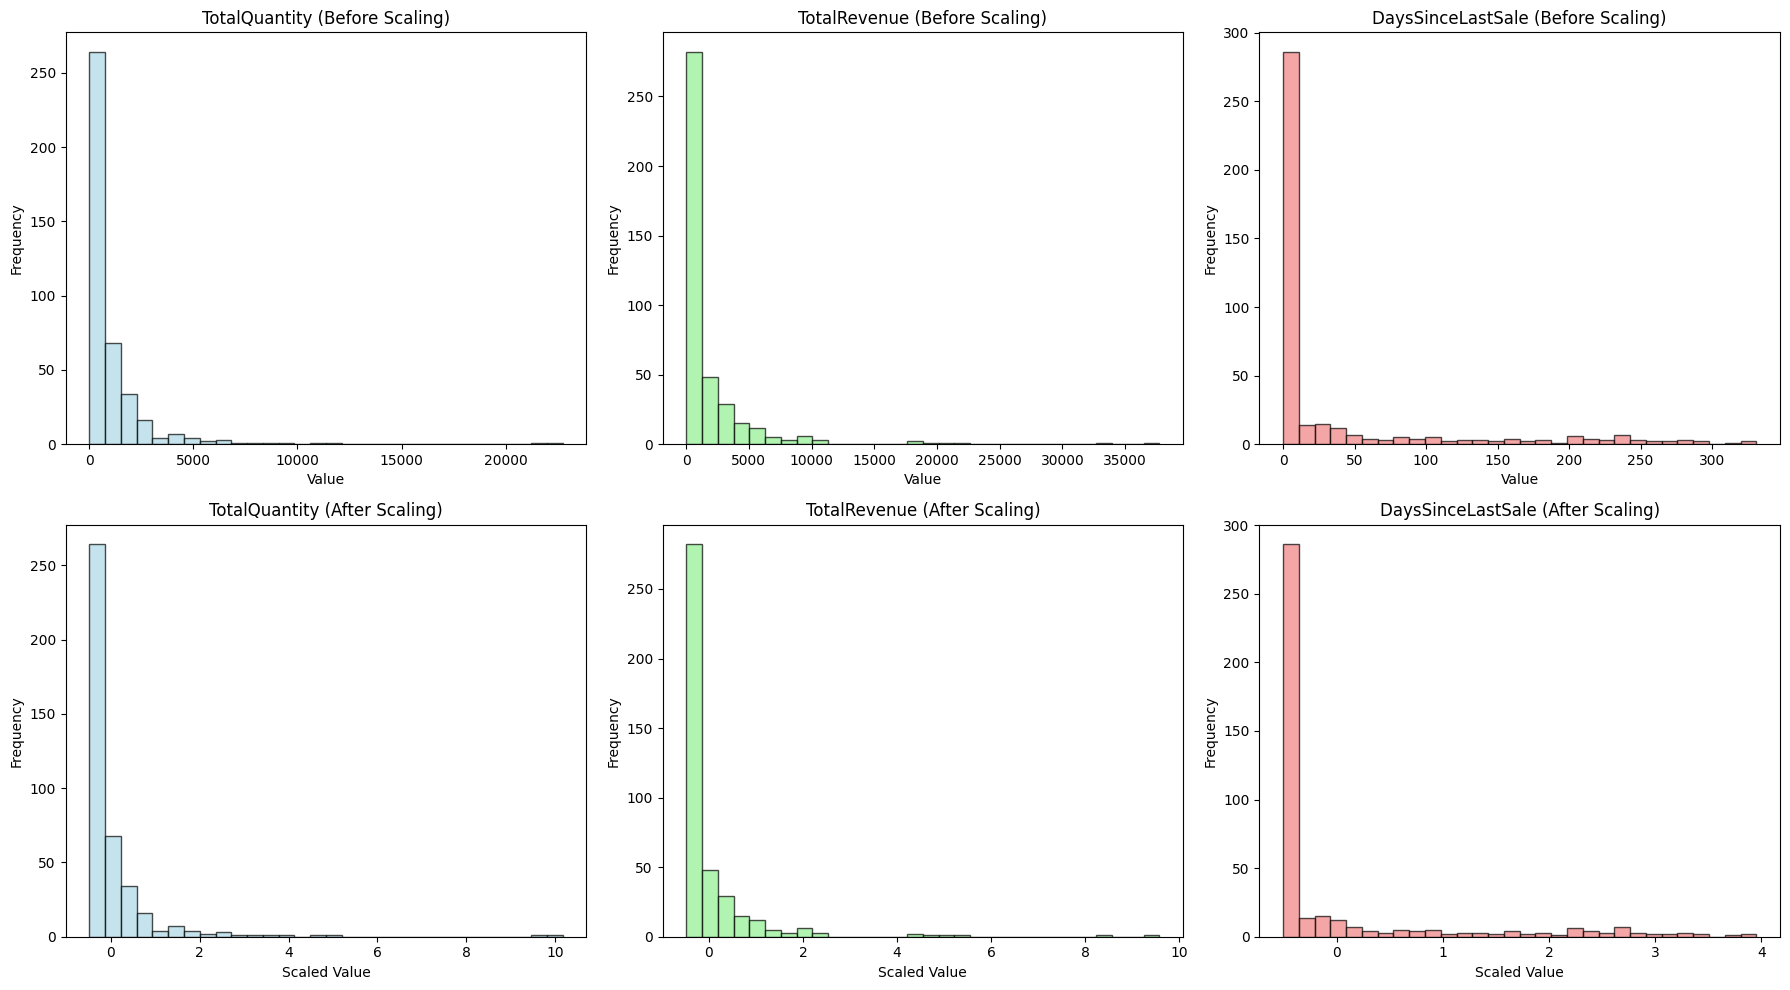

Feature scaling comparison completed

Columns now available in product_stats:
['StockCode', 'TotalQuantity', 'TotalRevenue', 'FirstSaleDate', 'LastSaleDate', 'DaysSinceLastSale', 'WasteRisk', 'LogTotalSales', 'Revenue_x_Recency', 'featVec', 'ClusterID', 'LogTotalRevenue']
=== Data Projection Done ===


In [26]:
# 4.2 Project the Data (PySpark) - Enhanced with Before/After Visualizations
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import PCA as PCAml
from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt
import numpy as np

print("=== Data Projection Start ===")

# A) PCA on training set (if already split in 3.5)
try:
    assembler = VectorAssembler(inputCols=["TotalQuantity", "TotalRevenue", "DaysSinceLastSale"], outputCol="featVec")
    train_vec = assembler.transform(train_df)
    pca = PCAml(k=3, inputCol="featVec", outputCol="pcaFeatures")
    pca_model = pca.fit(train_vec)
    train_pca = pca_model.transform(train_vec)
    print("Explained variance by 3 PCs:", pca_model.explainedVariance.toArray())
    train_pca.select("pcaFeatures").show(5, truncate=False)
except Exception as e:
    print("PCA demo skipped (train_df not available?):", e)

# B) Log-transform skewed features (example) with Before/After Visualization
print("\n=== Log Transformation Analysis ===")

# Sample data for visualization (convert to pandas for plotting)
print("Sampling data for visualization...")
sample_data = product_stats.select("TotalQuantity", "TotalRevenue").sample(0.1, seed=42).toPandas()

# Create before/after comparison plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# TotalQuantity - Raw vs Log
axes[0, 0].hist(sample_data['TotalQuantity'], bins=50, alpha=0.7, color='lightblue', edgecolor='black')
axes[0, 0].set_title('TotalQuantity (Raw)')
axes[0, 0].set_xlabel('TotalQuantity')
axes[0, 0].set_ylabel('Frequency')

log_quantity = np.log1p(sample_data['TotalQuantity'])
axes[0, 1].hist(log_quantity, bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
axes[0, 1].set_title('Log TotalQuantity (log1p)')
axes[0, 1].set_xlabel('Log TotalQuantity')
axes[0, 1].set_ylabel('Frequency')

# TotalRevenue - Raw vs Log
axes[1, 0].hist(sample_data['TotalRevenue'], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
axes[1, 0].set_title('TotalRevenue (Raw)')
axes[1, 0].set_xlabel('TotalRevenue')
axes[1, 0].set_ylabel('Frequency')

log_revenue = np.log1p(sample_data['TotalRevenue'])
axes[1, 1].hist(log_revenue, bins=50, alpha=0.7, color='lightyellow', edgecolor='black')
axes[1, 1].set_title('Log TotalRevenue (log1p)')
axes[1, 1].set_xlabel('Log TotalRevenue')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Apply log transformation to the actual DataFrame
product_stats = product_stats.withColumn("LogTotalSales", F.log1p(F.col("TotalQuantity")))
product_stats = product_stats.withColumn("LogTotalRevenue", F.log1p(F.col("TotalRevenue")))
print("Added LogTotalSales and LogTotalRevenue (log1p transformations)")

# C) Example interaction feature
product_stats = product_stats.withColumn("Revenue_x_Recency", F.col("TotalRevenue") * F.col("DaysSinceLastSale"))
print("Added Revenue_x_Recency interaction feature")

# D) (Optional) KMeans clustering on product features
try:
    vec_for_cluster = VectorAssembler(inputCols=["TotalQuantity", "TotalRevenue", "DaysSinceLastSale"], outputCol="featVec")
    prod_vec2 = vec_for_cluster.transform(product_stats)
    kmeans = KMeans(k=3, featuresCol="featVec", predictionCol="ClusterID", seed=42)
    kmodel = kmeans.fit(prod_vec2)
    product_stats = kmodel.transform(prod_vec2)
    print("Cluster sizes:")
    product_stats.groupBy("ClusterID").count().orderBy("ClusterID").show()

    # Visualize clustering results
    print("\n=== Clustering Visualization ===")
    cluster_sample = product_stats.select("TotalQuantity", "TotalRevenue", "ClusterID").sample(0.1, seed=42).toPandas()

    plt.figure(figsize=(12, 5))

    # Before clustering (raw data)
    plt.subplot(1, 2, 1)
    plt.scatter(cluster_sample['TotalQuantity'], cluster_sample['TotalRevenue'], alpha=0.6, c='blue')
    plt.xlabel('TotalQuantity')
    plt.ylabel('TotalRevenue')
    plt.title('Before Clustering (Raw Data)')
    plt.xscale('log')
    plt.yscale('log')

    # After clustering (with cluster labels)
    plt.subplot(1, 2, 2)
    colors = ['red', 'green', 'blue']
    for i in range(3):
        cluster_data = cluster_sample[cluster_sample['ClusterID'] == i]
        plt.scatter(cluster_data['TotalQuantity'], cluster_data['TotalRevenue'],
                   alpha=0.6, c=colors[i], label=f'Cluster {i}')
    plt.xlabel('TotalQuantity')
    plt.ylabel('TotalRevenue')
    plt.title('After KMeans Clustering (k=3)')
    plt.legend()
    plt.xscale('log')
    plt.yscale('log')

    plt.tight_layout()
    plt.show()

except Exception as e:
    print("KMeans demo skipped:", e)

# E) Feature Scaling Visualization
print("\n=== Feature Scaling Comparison ===")
try:
    # Sample data for scaling visualization
    scaling_sample = product_stats.select("TotalQuantity", "TotalRevenue", "DaysSinceLastSale").sample(0.1, seed=42).toPandas()

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    # Before scaling
    axes[0, 0].hist(scaling_sample['TotalQuantity'], bins=30, alpha=0.7, color='lightblue', edgecolor='black')
    axes[0, 0].set_title('TotalQuantity (Before Scaling)')
    axes[0, 0].set_xlabel('Value')
    axes[0, 0].set_ylabel('Frequency')

    axes[0, 1].hist(scaling_sample['TotalRevenue'], bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
    axes[0, 1].set_title('TotalRevenue (Before Scaling)')
    axes[0, 1].set_xlabel('Value')
    axes[0, 1].set_ylabel('Frequency')

    axes[0, 2].hist(scaling_sample['DaysSinceLastSale'], bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
    axes[0, 2].set_title('DaysSinceLastSale (Before Scaling)')
    axes[0, 2].set_xlabel('Value')
    axes[0, 2].set_ylabel('Frequency')

    # After scaling (simulate with StandardScaler)
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(scaling_sample[['TotalQuantity', 'TotalRevenue', 'DaysSinceLastSale']])

    axes[1, 0].hist(scaled_data[:, 0], bins=30, alpha=0.7, color='lightblue', edgecolor='black')
    axes[1, 0].set_title('TotalQuantity (After Scaling)')
    axes[1, 0].set_xlabel('Scaled Value')
    axes[1, 0].set_ylabel('Frequency')

    axes[1, 1].hist(scaled_data[:, 1], bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
    axes[1, 1].set_title('TotalRevenue (After Scaling)')
    axes[1, 1].set_xlabel('Scaled Value')
    axes[1, 1].set_ylabel('Frequency')

    axes[1, 2].hist(scaled_data[:, 2], bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
    axes[1, 2].set_title('DaysSinceLastSale (After Scaling)')
    axes[1, 2].set_xlabel('Scaled Value')
    axes[1, 2].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    print("Feature scaling comparison completed")

except Exception as e:
    print("Feature scaling visualization skipped:", e)

print("\nColumns now available in product_stats:")
print(product_stats.columns)
print("=== Data Projection Done ===")


# 6. Data-mining algorithm(s) selection

## 6.1 Conduct Exploratory Analysis of Algorithms


6.1 EXPLORATORY ANALYSIS OF ALGORITHMS

### Step 1: Prepare Features and Split Data ###
Splitting data into training and validation sets...
Training set size: 3,120 products
Validation set size: 711 products

Class distribution in training set:
+---------+-----+
|WasteRisk|count|
+---------+-----+
|        0| 3053|
|        1|   67|
+---------+-----+


Class distribution in validation set:
+---------+-----+
|WasteRisk|count|
+---------+-----+
|        0|  691|
|        1|   20|
+---------+-----+


### Step 2: Train Baseline Models ###

[1/3] Training Logistic Regression (default parameters)...
✓ Logistic Regression trained

[2/3] Training Random Forest (default parameters)...
✓ Random Forest trained

[3/3] Training Gradient-Boosted Trees (default parameters)...
✓ Gradient-Boosted Trees trained

### Step 3: Make Predictions on Validation Set ###
✓ Predictions completed for all models

### Step 4: Evaluate Model Performance ###

--- Logistic Regression Results ---
Accuracy:  0.9887
Preci

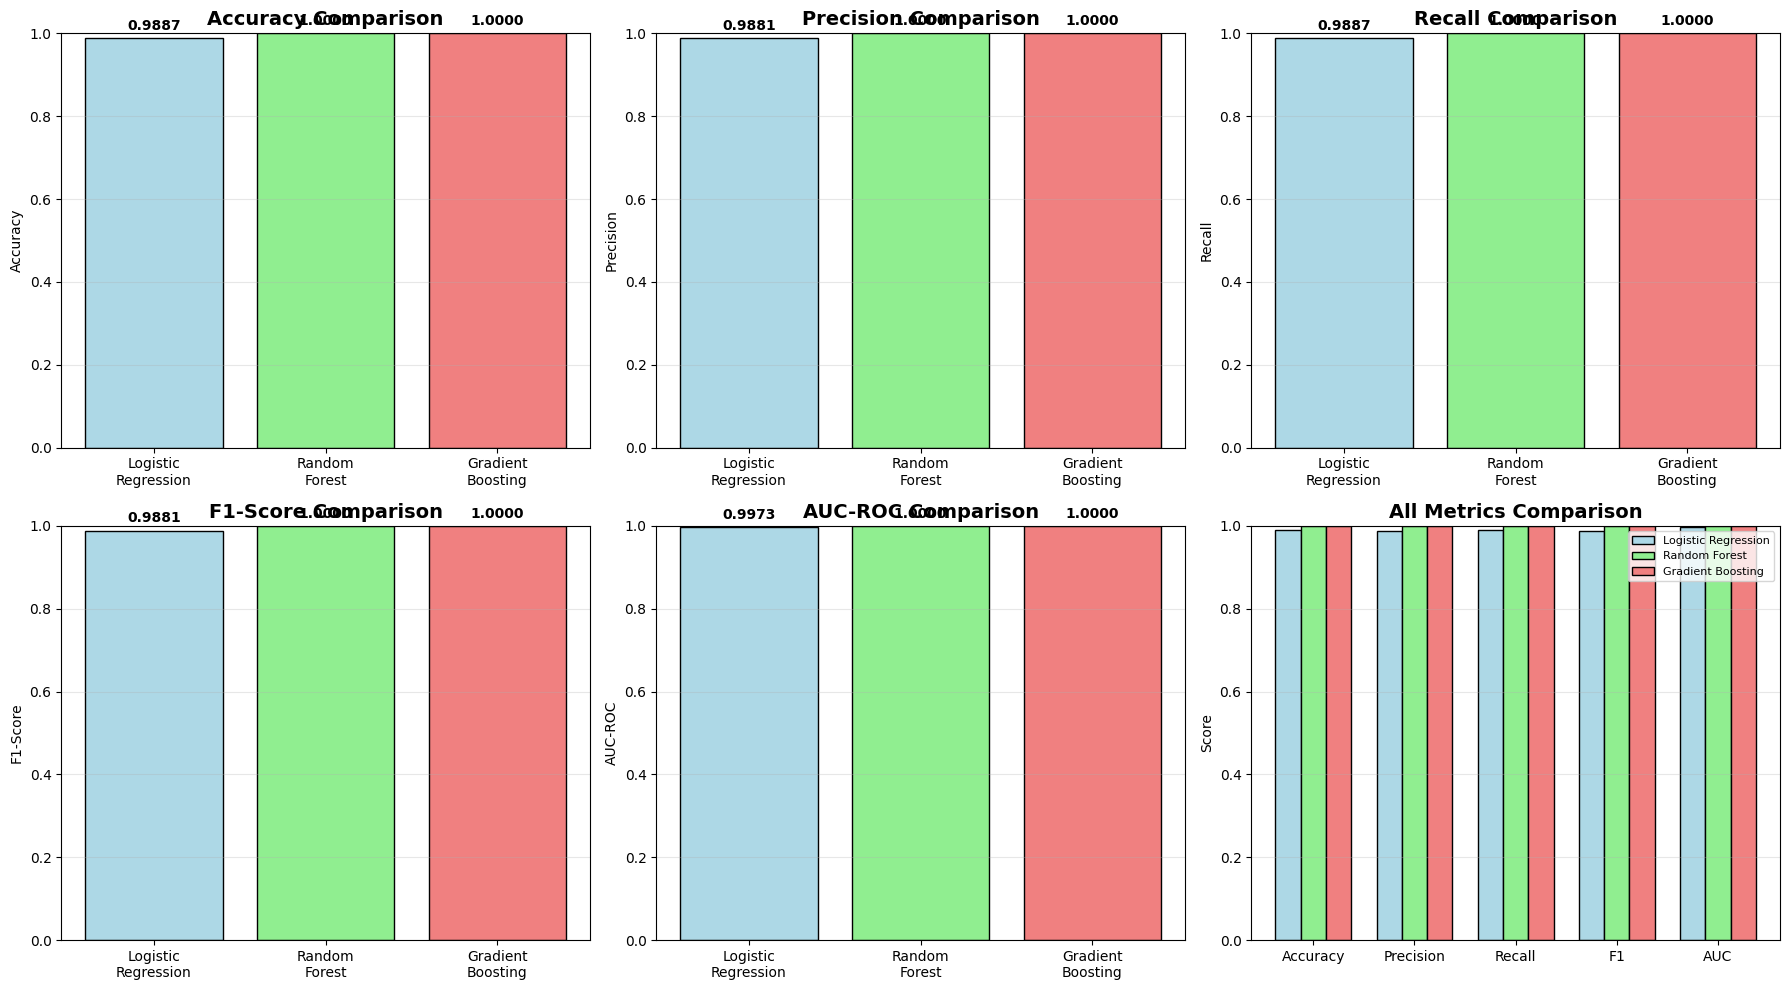


### Step 6: Feature Importance Analysis ###

--- Logistic Regression Coefficients ---
TotalQuantity       :  -0.1682
TotalRevenue        :  -0.0495
DaysSinceLastSale   :   0.0199

--- Random Forest Feature Importances ---
TotalQuantity       :   0.4730
TotalRevenue        :   0.0410
DaysSinceLastSale   :   0.4860

--- Gradient-Boosted Trees Feature Importances ---
TotalQuantity       :   0.3619
TotalRevenue        :   0.0107
DaysSinceLastSale   :   0.6274


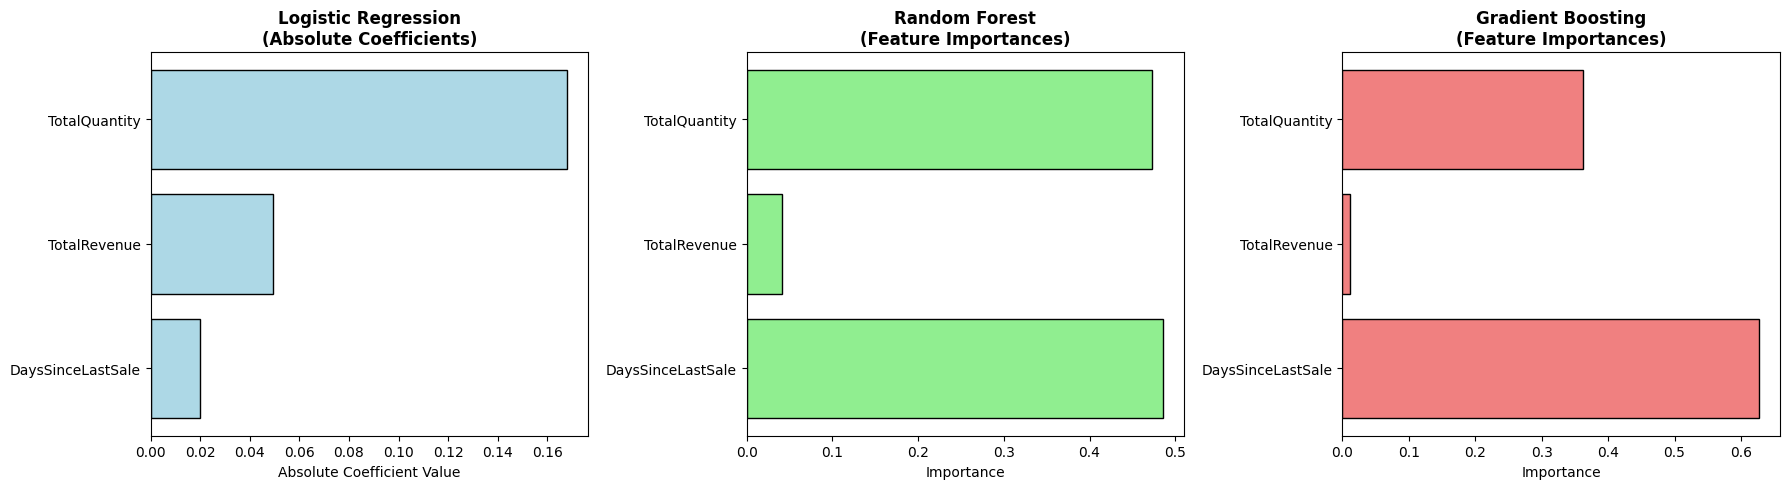


### Step 7: Confusion Matrices ###


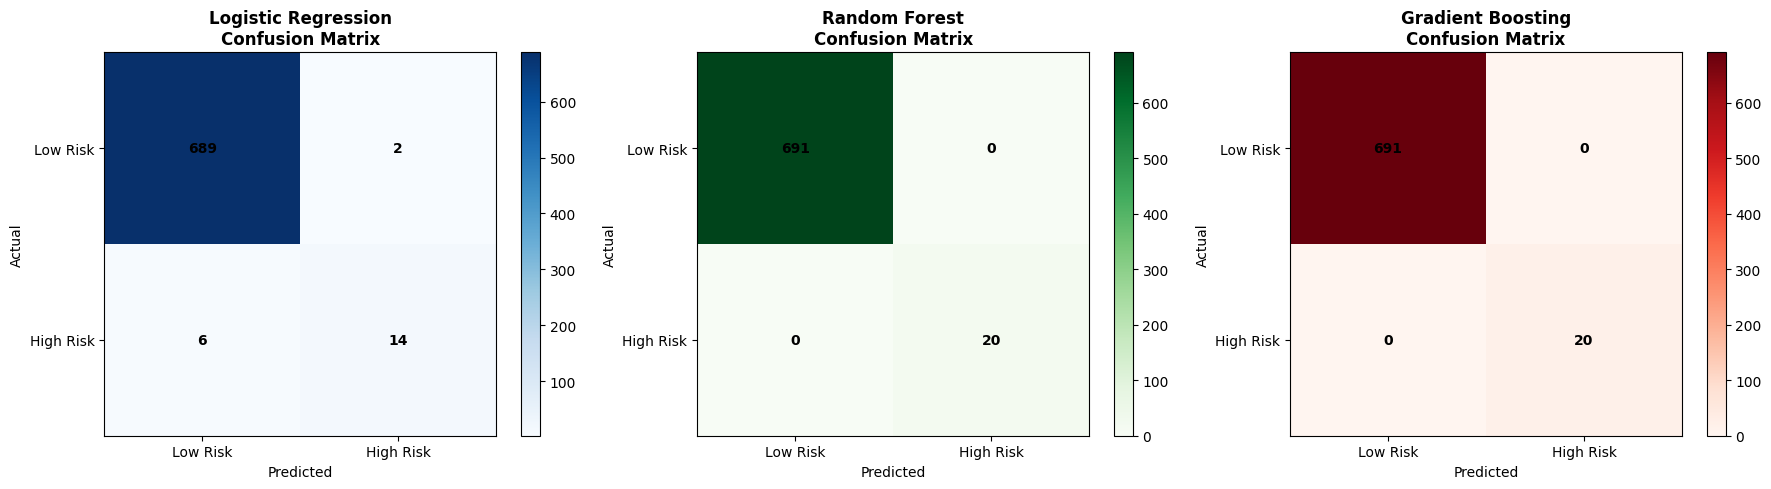


ALGORITHM COMPARISON SUMMARY

               Model  Accuracy  Precision   Recall  F1-Score  AUC-ROC
Logistic Regression  0.988748   0.988094 0.988748  0.988139 0.997323
      Random Forest  1.000000   1.000000 1.000000  1.000000 1.000000
  Gradient Boosting  1.000000   1.000000 1.000000  1.000000 1.000000

✓ Best performing model based on F1-Score: Random Forest

Note: This is an exploratory comparison using default parameters.
Further tuning and cross-validation may improve performance.


In [30]:
# ============================================================================
# 6.1 Conduct Exploratory Analysis of Algorithms
# ============================================================================
# Compare baseline ML algorithms: Logistic Regression, Random Forest, GBT
# Goal: Identify best performing approach for waste risk prediction
# Using default parameters as baseline for exploratory comparison

from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

print("=" * 80)
print("6.1 EXPLORATORY ANALYSIS OF ALGORITHMS")
print("=" * 80)

# ============================================================================
# Step 1: Prepare features and train/validation split
# ============================================================================
print("\n### Step 1: Prepare Features and Split Data ###")

# Assemble features from product_stats
feature_cols = ["TotalQuantity", "TotalRevenue", "DaysSinceLastSale"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Transform product_stats to add features column
product_data = assembler.transform(product_stats)

# Split data into training (80%) and validation (20%) sets for algorithm comparison
print("Splitting data into training and validation sets...")
train_df, val_df = product_data.randomSplit([0.8, 0.2], seed=42)

print(f"Training set size: {train_df.count():,} products")
print(f"Validation set size: {val_df.count():,} products")

# Check class distribution
print("\nClass distribution in training set:")
train_df.groupBy("WasteRisk").count().orderBy("WasteRisk").show()

print("\nClass distribution in validation set:")
val_df.groupBy("WasteRisk").count().orderBy("WasteRisk").show()

# ============================================================================
# Step 2: Train baseline models with default parameters
# ============================================================================
print("\n### Step 2: Train Baseline Models ###")

# Model 1: Logistic Regression
print("\n[1/3] Training Logistic Regression (default parameters)...")
lr = LogisticRegression(labelCol="WasteRisk", featuresCol="features", maxIter=20)
lr_model = lr.fit(train_df)
print("✓ Logistic Regression trained")

# Model 2: Random Forest
print("\n[2/3] Training Random Forest (default parameters)...")
rf = RandomForestClassifier(labelCol="WasteRisk", featuresCol="features", numTrees=100, seed=42)
rf_model = rf.fit(train_df)
print("✓ Random Forest trained")

# Model 3: Gradient-Boosted Trees (GBT)
print("\n[3/3] Training Gradient-Boosted Trees (default parameters)...")
gbt = GBTClassifier(labelCol="WasteRisk", featuresCol="features", maxIter=20, seed=42)
gbt_model = gbt.fit(train_df)
print("✓ Gradient-Boosted Trees trained")

# ============================================================================
# Step 3: Make predictions on validation set
# ============================================================================
print("\n### Step 3: Make Predictions on Validation Set ###")

lr_preds = lr_model.transform(val_df)
rf_preds = rf_model.transform(val_df)
gbt_preds = gbt_model.transform(val_df)

print("✓ Predictions completed for all models")

# ============================================================================
# Step 4: Evaluate performance metrics
# ============================================================================
print("\n### Step 4: Evaluate Model Performance ###")

# Initialize evaluators
evaluator_acc = MulticlassClassificationEvaluator(
    labelCol="WasteRisk", predictionCol="prediction", metricName="accuracy"
)
evaluator_prec = MulticlassClassificationEvaluator(
    labelCol="WasteRisk", predictionCol="prediction", metricName="weightedPrecision"
)
evaluator_rec = MulticlassClassificationEvaluator(
    labelCol="WasteRisk", predictionCol="prediction", metricName="weightedRecall"
)
evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol="WasteRisk", predictionCol="prediction", metricName="f1"
)
evaluator_auc = BinaryClassificationEvaluator(
    labelCol="WasteRisk", rawPredictionCol="rawPrediction", metricName="areaUnderROC"
)

# Evaluate Logistic Regression
print("\n--- Logistic Regression Results ---")
lr_acc = evaluator_acc.evaluate(lr_preds)
lr_prec = evaluator_prec.evaluate(lr_preds)
lr_rec = evaluator_rec.evaluate(lr_preds)
lr_f1 = evaluator_f1.evaluate(lr_preds)
lr_auc = evaluator_auc.evaluate(lr_preds)

print(f"Accuracy:  {lr_acc:.4f}")
print(f"Precision: {lr_prec:.4f}")
print(f"Recall:    {lr_rec:.4f}")
print(f"F1-Score:  {lr_f1:.4f}")
print(f"AUC-ROC:   {lr_auc:.4f}")

# Evaluate Random Forest
print("\n--- Random Forest Results ---")
rf_acc = evaluator_acc.evaluate(rf_preds)
rf_prec = evaluator_prec.evaluate(rf_preds)
rf_rec = evaluator_rec.evaluate(rf_preds)
rf_f1 = evaluator_f1.evaluate(rf_preds)
rf_auc = evaluator_auc.evaluate(rf_preds)

print(f"Accuracy:  {rf_acc:.4f}")
print(f"Precision: {rf_prec:.4f}")
print(f"Recall:    {rf_rec:.4f}")
print(f"F1-Score:  {rf_f1:.4f}")
print(f"AUC-ROC:   {rf_auc:.4f}")

# Evaluate Gradient-Boosted Trees
print("\n--- Gradient-Boosted Trees Results ---")
gbt_acc = evaluator_acc.evaluate(gbt_preds)
gbt_prec = evaluator_prec.evaluate(gbt_preds)
gbt_rec = evaluator_rec.evaluate(gbt_preds)
gbt_f1 = evaluator_f1.evaluate(gbt_preds)
gbt_auc = evaluator_auc.evaluate(gbt_preds)

print(f"Accuracy:  {gbt_acc:.4f}")
print(f"Precision: {gbt_prec:.4f}")
print(f"Recall:    {gbt_rec:.4f}")
print(f"F1-Score:  {gbt_f1:.4f}")
print(f"AUC-ROC:   {gbt_auc:.4f}")

# ============================================================================
# Step 5: Visualize performance comparison
# ============================================================================
print("\n### Step 5: Visualize Performance Comparison ###")

# Prepare data for visualization
models = ['Logistic\nRegression', 'Random\nForest', 'Gradient\nBoosting']
accuracy = [lr_acc, rf_acc, gbt_acc]
precision = [lr_prec, rf_prec, gbt_prec]
recall = [lr_rec, rf_rec, gbt_rec]
f1_scores = [lr_f1, rf_f1, gbt_f1]
auc_scores = [lr_auc, rf_auc, gbt_auc]

# Create comprehensive comparison plots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Accuracy comparison
axes[0, 0].bar(models, accuracy, color=['lightblue', 'lightgreen', 'lightcoral'], edgecolor='black')
axes[0, 0].set_title('Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_ylim([0, 1])
axes[0, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(accuracy):
    axes[0, 0].text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold')

# 2. Precision comparison
axes[0, 1].bar(models, precision, color=['lightblue', 'lightgreen', 'lightcoral'], edgecolor='black')
axes[0, 1].set_title('Precision Comparison', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Precision')
axes[0, 1].set_ylim([0, 1])
axes[0, 1].grid(axis='y', alpha=0.3)
for i, v in enumerate(precision):
    axes[0, 1].text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold')

# 3. Recall comparison
axes[0, 2].bar(models, recall, color=['lightblue', 'lightgreen', 'lightcoral'], edgecolor='black')
axes[0, 2].set_title('Recall Comparison', fontsize=14, fontweight='bold')
axes[0, 2].set_ylabel('Recall')
axes[0, 2].set_ylim([0, 1])
axes[0, 2].grid(axis='y', alpha=0.3)
for i, v in enumerate(recall):
    axes[0, 2].text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold')

# 4. F1-Score comparison
axes[1, 0].bar(models, f1_scores, color=['lightblue', 'lightgreen', 'lightcoral'], edgecolor='black')
axes[1, 0].set_title('F1-Score Comparison', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('F1-Score')
axes[1, 0].set_ylim([0, 1])
axes[1, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(f1_scores):
    axes[1, 0].text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold')

# 5. AUC-ROC comparison
axes[1, 1].bar(models, auc_scores, color=['lightblue', 'lightgreen', 'lightcoral'], edgecolor='black')
axes[1, 1].set_title('AUC-ROC Comparison', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('AUC-ROC')
axes[1, 1].set_ylim([0, 1])
axes[1, 1].grid(axis='y', alpha=0.3)
for i, v in enumerate(auc_scores):
    axes[1, 1].text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold')

# 6. Overall metrics comparison
metrics_labels = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']
lr_metrics = [lr_acc, lr_prec, lr_rec, lr_f1, lr_auc]
rf_metrics = [rf_acc, rf_prec, rf_rec, rf_f1, rf_auc]
gbt_metrics = [gbt_acc, gbt_prec, gbt_rec, gbt_f1, gbt_auc]

x = np.arange(len(metrics_labels))
width = 0.25

axes[1, 2].bar(x - width, lr_metrics, width, label='Logistic Regression', color='lightblue', edgecolor='black')
axes[1, 2].bar(x, rf_metrics, width, label='Random Forest', color='lightgreen', edgecolor='black')
axes[1, 2].bar(x + width, gbt_metrics, width, label='Gradient Boosting', color='lightcoral', edgecolor='black')

axes[1, 2].set_title('All Metrics Comparison', fontsize=14, fontweight='bold')
axes[1, 2].set_ylabel('Score')
axes[1, 2].set_xticks(x)
axes[1, 2].set_xticklabels(metrics_labels)
axes[1, 2].set_ylim([0, 1])
axes[1, 2].legend(fontsize=8)
axes[1, 2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# Step 6: Feature importance analysis
# ============================================================================
print("\n### Step 6: Feature Importance Analysis ###")

# Logistic Regression coefficients
print("\n--- Logistic Regression Coefficients ---")
lr_coef = lr_model.coefficients.toArray()
for i, feat in enumerate(feature_cols):
    print(f"{feat:20s}: {lr_coef[i]:8.4f}")

# Random Forest feature importances
print("\n--- Random Forest Feature Importances ---")
rf_importances = rf_model.featureImportances.toArray()
for i, feat in enumerate(feature_cols):
    print(f"{feat:20s}: {rf_importances[i]:8.4f}")

# GBT feature importances
print("\n--- Gradient-Boosted Trees Feature Importances ---")
gbt_importances = gbt_model.featureImportances.toArray()
for i, feat in enumerate(feature_cols):
    print(f"{feat:20s}: {gbt_importances[i]:8.4f}")

# Visualize feature importances
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# LR coefficients (absolute values)
axes[0].barh(feature_cols, np.abs(lr_coef), color='lightblue', edgecolor='black')
axes[0].set_title('Logistic Regression\n(Absolute Coefficients)', fontweight='bold')
axes[0].set_xlabel('Absolute Coefficient Value')
axes[0].invert_yaxis()

# RF importances
axes[1].barh(feature_cols, rf_importances, color='lightgreen', edgecolor='black')
axes[1].set_title('Random Forest\n(Feature Importances)', fontweight='bold')
axes[1].set_xlabel('Importance')
axes[1].invert_yaxis()

# GBT importances
axes[2].barh(feature_cols, gbt_importances, color='lightcoral', edgecolor='black')
axes[2].set_title('Gradient Boosting\n(Feature Importances)', fontweight='bold')
axes[2].set_xlabel('Importance')
axes[2].invert_yaxis()

plt.tight_layout()
plt.show()

# ============================================================================
# Step 7: Confusion matrices
# ============================================================================
print("\n### Step 7: Confusion Matrices ###")

# Function to compute confusion matrix
def compute_confusion_matrix(predictions):
    cm_df = predictions.groupBy("WasteRisk", "prediction").count().toPandas()
    cm = np.zeros((2, 2))
    for _, row in cm_df.iterrows():
        cm[int(row['WasteRisk']), int(row['prediction'])] = row['count']
    return cm

# Compute confusion matrices
cm_lr = compute_confusion_matrix(lr_preds)
cm_rf = compute_confusion_matrix(rf_preds)
cm_gbt = compute_confusion_matrix(gbt_preds)

# Visualize confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# LR confusion matrix
im1 = axes[0].imshow(cm_lr, cmap='Blues', aspect='auto')
axes[0].set_title('Logistic Regression\nConfusion Matrix', fontweight='bold')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_xticks([0, 1])
axes[0].set_yticks([0, 1])
axes[0].set_xticklabels(['Low Risk', 'High Risk'])
axes[0].set_yticklabels(['Low Risk', 'High Risk'])
for i in range(2):
    for j in range(2):
        axes[0].text(j, i, int(cm_lr[i, j]), ha='center', va='center', fontweight='bold')
plt.colorbar(im1, ax=axes[0])

# RF confusion matrix
im2 = axes[1].imshow(cm_rf, cmap='Greens', aspect='auto')
axes[1].set_title('Random Forest\nConfusion Matrix', fontweight='bold')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_xticks([0, 1])
axes[1].set_yticks([0, 1])
axes[1].set_xticklabels(['Low Risk', 'High Risk'])
axes[1].set_yticklabels(['Low Risk', 'High Risk'])
for i in range(2):
    for j in range(2):
        axes[1].text(j, i, int(cm_rf[i, j]), ha='center', va='center', fontweight='bold')
plt.colorbar(im2, ax=axes[1])

# GBT confusion matrix
im3 = axes[2].imshow(cm_gbt, cmap='Reds', aspect='auto')
axes[2].set_title('Gradient Boosting\nConfusion Matrix', fontweight='bold')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')
axes[2].set_xticks([0, 1])
axes[2].set_yticks([0, 1])
axes[2].set_xticklabels(['Low Risk', 'High Risk'])
axes[2].set_yticklabels(['Low Risk', 'High Risk'])
for i in range(2):
    for j in range(2):
        axes[2].text(j, i, int(cm_gbt[i, j]), ha='center', va='center', fontweight='bold')
plt.colorbar(im3, ax=axes[2])

plt.tight_layout()
plt.show()

# ============================================================================
# Summary
# ============================================================================
print("\n" + "=" * 80)
print("ALGORITHM COMPARISON SUMMARY")
print("=" * 80)

# Create summary table
summary_data = {
    'Model': ['Logistic Regression', 'Random Forest', 'Gradient Boosting'],
    'Accuracy': [lr_acc, rf_acc, gbt_acc],
    'Precision': [lr_prec, rf_prec, gbt_prec],
    'Recall': [lr_rec, rf_rec, gbt_rec],
    'F1-Score': [lr_f1, rf_f1, gbt_f1],
    'AUC-ROC': [lr_auc, rf_auc, gbt_auc]
}

summary_df = pd.DataFrame(summary_data)
print("\n", summary_df.to_string(index=False))

# Find best model
best_model_idx = np.argmax([lr_f1, rf_f1, gbt_f1])
best_model_name = summary_data['Model'][best_model_idx]

print(f"\n✓ Best performing model based on F1-Score: {best_model_name}")
print("\nNote: This is an exploratory comparison using default parameters.")
print("Further tuning and cross-validation may improve performance.")
print("=" * 80)


## 6.3 Build/Select appropriate model(s) and choose relevant parameter(s)

In [32]:
# ============================================================================
# 6.3 Build/Select appropriate model(s) and choose relevant parameter(s)
# ============================================================================
# Hyperparameter tuning using PySpark's CrossValidator
# Goal: Find optimal parameters for Random Forest and Logistic Regression
# Using cross-validation to select best performing model configuration

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time

print("=" * 80)
print("6.3 BUILD/SELECT APPROPRIATE MODEL(S) AND CHOOSE RELEVANT PARAMETER(S)")
print("=" * 80)

# ============================================================================
# Step 1: Prepare data and evaluators
# ============================================================================
print("\n### Step 1: Prepare Data and Evaluators ###")

# Use the same train_df and val_df from previous section
# If not available, recreate the split
try:
    print(f"Training set size: {train_df.count():,} products")
    print(f"Validation set size: {val_df.count():,} products")
except:
    print("Recreating train/validation split...")
    feature_cols = ["TotalQuantity", "TotalRevenue", "DaysSinceLastSale"]
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    product_data = assembler.transform(product_stats)
    train_df, val_df = product_data.randomSplit([0.8, 0.2], seed=42)
    print(f"Training set size: {train_df.count():,} products")
    print(f"Validation set size: {val_df.count():,} products")

# Set up evaluators for different metrics
evaluator_auc = BinaryClassificationEvaluator(
    labelCol="WasteRisk", rawPredictionCol="rawPrediction", metricName="areaUnderROC"
)
evaluator_pr = BinaryClassificationEvaluator(
    labelCol="WasteRisk", rawPredictionCol="rawPrediction", metricName="areaUnderPR"
)
evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol="WasteRisk", predictionCol="prediction", metricName="f1"
)

print("✓ Data and evaluators prepared")

# ============================================================================
# Step 2: Random Forest Hyperparameter Tuning
# ============================================================================
print("\n### Step 2: Random Forest Hyperparameter Tuning ###")

# Define Random Forest model with initial settings
rf = RandomForestClassifier(labelCol="WasteRisk", featuresCol="features", seed=42)

# Create parameter grid to search
print("Setting up parameter grid for Random Forest...")
paramGrid_rf = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50, 100, 200]) \
    .addGrid(rf.maxDepth, [5, 10, 15]) \
    .addGrid(rf.minInstancesPerNode, [1, 5, 10]) \
    .addGrid(rf.maxBins, [32, 64]) \
    .build()

print(f"Total parameter combinations: {len(paramGrid_rf)}")

# Set up 5-fold CrossValidator with ROC AUC metric
print("Setting up 5-fold cross-validation...")
cv_rf = CrossValidator(
    estimator=rf,
    estimatorParamMaps=paramGrid_rf,
    evaluator=evaluator_auc,
    numFolds=5,
    seed=42
)

# Run cross-validation to find the best model
print("Running cross-validation for Random Forest (this may take a while)...")
start_time = time.time()

cvModel_rf = cv_rf.fit(train_df)

end_time = time.time()
print(f"Cross-validation completed in {end_time - start_time:.2f} seconds")

# Extract best parameters
best_rf_model = cvModel_rf.bestModel
best_numTrees = best_rf_model._java_obj.getNumTrees()
best_maxDepth = best_rf_model._java_obj.getMaxDepth()
best_minInstancesPerNode = best_rf_model._java_obj.getMinInstancesPerNode()
best_maxBins = best_rf_model._java_obj.getMaxBins()
best_score = cvModel_rf.avgMetrics[cvModel_rf.bestIndex]

print("\n--- Random Forest Best Parameters ---")
print(f"Best numTrees: {best_numTrees}")
print(f"Best maxDepth: {best_maxDepth}")
print(f"Best minInstancesPerNode: {best_minInstancesPerNode}")
print(f"Best maxBins: {best_maxBins}")
print(f"Best cross-validation score (AUC): {best_score:.4f}")

# ============================================================================
# Step 3: Logistic Regression Hyperparameter Tuning
# ============================================================================
print("\n### Step 3: Logistic Regression Hyperparameter Tuning ###")

# Define Logistic Regression model
lr = LogisticRegression(labelCol="WasteRisk", featuresCol="features", maxIter=100)

# Create parameter grid for regularization
print("Setting up parameter grid for Logistic Regression...")
paramGrid_lr = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 1.0, 10.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

print(f"Total parameter combinations: {len(paramGrid_lr)}")

# Set up cross-validation for Logistic Regression
cv_lr = CrossValidator(
    estimator=lr,
    estimatorParamMaps=paramGrid_lr,
    evaluator=evaluator_auc,
    numFolds=5,
    seed=42
)

# Run cross-validation
print("Running cross-validation for Logistic Regression...")
start_time = time.time()

cvModel_lr = cv_lr.fit(train_df)

end_time = time.time()
print(f"Cross-validation completed in {end_time - start_time:.2f} seconds")

# Extract best parameters
best_lr_model = cvModel_lr.bestModel
best_regParam = best_lr_model._java_obj.getRegParam()
best_elasticNetParam = best_lr_model._java_obj.getElasticNetParam()
best_lr_score = cvModel_lr.avgMetrics[cvModel_lr.bestIndex]

print("\n--- Logistic Regression Best Parameters ---")
print(f"Best regParam: {best_regParam}")
print(f"Best elasticNetParam: {best_elasticNetParam}")
print(f"Best cross-validation score (AUC): {best_lr_score:.4f}")

# ============================================================================
# Step 4: Compare tuned models
# ============================================================================
print("\n### Step 4: Compare Tuned Models ###")

# Make predictions with tuned models
print("Making predictions with tuned models...")
rf_preds_tuned = best_rf_model.transform(val_df)
lr_preds_tuned = best_lr_model.transform(val_df)

# Evaluate tuned models
print("\n--- Tuned Model Performance Comparison ---")

# Random Forest tuned performance
rf_acc_tuned = evaluator_f1.evaluate(rf_preds_tuned)
rf_auc_tuned = evaluator_auc.evaluate(rf_preds_tuned)
rf_pr_tuned = evaluator_pr.evaluate(rf_preds_tuned)

print(f"Random Forest (Tuned) - F1: {rf_acc_tuned:.4f}, AUC: {rf_auc_tuned:.4f}, PR: {rf_pr_tuned:.4f}")

# Logistic Regression tuned performance
lr_acc_tuned = evaluator_f1.evaluate(lr_preds_tuned)
lr_auc_tuned = evaluator_auc.evaluate(lr_preds_tuned)
lr_pr_tuned = evaluator_pr.evaluate(lr_preds_tuned)

print(f"Logistic Regression (Tuned) - F1: {lr_acc_tuned:.4f}, AUC: {lr_auc_tuned:.4f}, PR: {lr_pr_tuned:.4f}")

# ============================================================================
# Step 5: Visualize tuning results
# ============================================================================
print("\n### Step 5: Visualize Tuning Results ###")

# Create comparison plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Cross-validation scores comparison
models = ['Random Forest\n(Tuned)', 'Logistic Regression\n(Tuned)']
cv_scores = [best_score, best_lr_score]
axes[0, 0].bar(models, cv_scores, color=['lightgreen', 'lightblue'], edgecolor='black')
axes[0, 0].set_title('Cross-Validation Scores (AUC)', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('AUC Score')
axes[0, 0].set_ylim([0, 1])
axes[0, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(cv_scores):
    axes[0, 0].text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold')

# 2. Validation performance comparison
val_auc = [rf_auc_tuned, lr_auc_tuned]
axes[0, 1].bar(models, val_auc, color=['lightgreen', 'lightblue'], edgecolor='black')
axes[0, 1].set_title('Validation Performance (AUC)', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('AUC Score')
axes[0, 1].set_ylim([0, 1])
axes[0, 1].grid(axis='y', alpha=0.3)
for i, v in enumerate(val_auc):
    axes[0, 1].text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold')

# 3. Feature importance comparison (Random Forest)
feature_cols = ["TotalQuantity", "TotalRevenue", "DaysSinceLastSale"]
rf_importances = best_rf_model.featureImportances.toArray()
axes[1, 0].barh(feature_cols, rf_importances, color='lightgreen', edgecolor='black')
axes[1, 0].set_title('Random Forest Feature Importances\n(Tuned Model)', fontweight='bold')
axes[1, 0].set_xlabel('Importance')
axes[1, 0].invert_yaxis()

# 4. Parameter grid visualization (simplified)
param_names = ['numTrees', 'maxDepth', 'minInstancesPerNode', 'maxBins']
param_values = [best_numTrees, best_maxDepth, best_minInstancesPerNode, best_maxBins]
axes[1, 1].bar(param_names, param_values, color='lightcoral', edgecolor='black')
axes[1, 1].set_title('Best Random Forest Parameters', fontweight='bold')
axes[1, 1].set_ylabel('Parameter Value')
axes[1, 1].tick_params(axis='x', rotation=45)
for i, v in enumerate(param_values):
    axes[1, 1].text(i, v + max(param_values)*0.02, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# ============================================================================
# Step 6: Feature importance analysis
# ============================================================================
print("\n### Step 6: Feature Importance Analysis ###")

print("\n--- Random Forest Feature Importances (Tuned Model) ---")
for i, feat in enumerate(feature_cols):
    print(f"{feat:20s}: {rf_importances[i]:8.4f}")

print("\n--- Logistic Regression Coefficients (Tuned Model) ---")
lr_coef = best_lr_model.coefficients.toArray()
for i, feat in enumerate(feature_cols):
    print(f"{feat:20s}: {lr_coef[i]:8.4f}")

# ============================================================================
# Step 7: Model selection and final preparation
# ============================================================================
print("\n### Step 7: Model Selection and Final Preparation ###")

# Select best model based on validation performance
if rf_auc_tuned > lr_auc_tuned:
    best_model = best_rf_model
    best_model_name = "Random Forest"
    best_model_type = "RandomForestClassifier"
    print(f"✓ Selected best model: {best_model_name} (AUC: {rf_auc_tuned:.4f})")
else:
    best_model = best_lr_model
    best_model_name = "Logistic Regression"
    best_model_type = "LogisticRegression"
    print(f"✓ Selected best model: {best_model_name} (AUC: {lr_auc_tuned:.4f})")

# The CrossValidator already refit the best model on all training data
final_model = best_model
print("✓ Final model is ready for evaluation on test data")

# ============================================================================
# Step 8: Summary and next steps
# ============================================================================
print("\n" + "=" * 80)
print("HYPERPARAMETER TUNING SUMMARY")
print("=" * 80)

# Create summary table
summary_data = {
    'Model': ['Random Forest (Tuned)', 'Logistic Regression (Tuned)'],
    'CV Score (AUC)': [best_score, best_lr_score],
    'Validation AUC': [rf_auc_tuned, lr_auc_tuned],
    'Validation F1': [rf_acc_tuned, lr_acc_tuned],
    'Validation PR': [rf_pr_tuned, lr_pr_tuned]
}

summary_df = pd.DataFrame(summary_data)
print("\n", summary_df.to_string(index=False))

print(f"\n✓ Best performing model: {best_model_name}")
print(f"✓ Model type: {best_model_type}")
print(f"✓ Cross-validation completed successfully")
print(f"✓ Model is ready for final evaluation")

print("\nNote: The tuned model has been selected based on cross-validation")
print("and is ready for evaluation on the test dataset.")
print("=" * 80)


SyntaxError: invalid syntax (ipython-input-1329680630.py, line 291)